# Sheet

# An exploratory analysis of traffic counts in the Copenhagen metropolitan area

<div class="alert alert-block alert-success">

  <strong>Success!</strong> Indicates a successful or positive action.
</div>

<div class="alert alert-block alert-info">

  <strong>Info!</strong> Indicates a neutral informative change or action.
</div>

<div class="alert alert-block alert-warning">

  <strong>Warning!</strong> Indicates a warning that might need attention.
</div>

<div class="alert alert-block alert-danger">

  <strong>Danger!</strong> Indicates a dangerous or potentially negative action.
</div>

# Sections
* Explorative analysis der kigger på forklarende faktorer som lockdown og benzinpriser
* Kig på hastighedsdata - kører folk hurtigere/langsommere under corona/høje benzinpriser f.eks.
* Animeret geoplot hvor hver målestation er en prik der i løbet af coronakrisen (2020-2022) skifter størrelse/farve efter aktivitet/hastighed eller whatever
* Noget bokeh


## Preliminary (Laura)
* Map-plot som viser lokation af de forskelliger tællere/gader (evt. med farve el. størrelse baseret på gennemsnitslig antal biler)
* Forklarende plots og tekst af vores datasæt, som gengiver størrelse, distribution, forklarer vores valg af datasæt
* Undersøg tidligere analyser af samme 'problem'???

## Coronatiden (Thomas)
* Ups and downs patterns i count
* Koble sammen med

## Fuel prices/predictions (Mikkel)
* Korrelation mellem benzinpriser og count
* ML model?
* 

### Reading guide <a id="test">

bla bla bla

## Questions for video
### An explanation of the central idea behind your final project, e.g. think about questions such as:
##### What is the idea?
During the last few years, the societal behaviour of transportation has changed. At first, lockdowns throughout Denmark put limitations or different requirements on the way we travel. More recently, the rise of gas prices may have had similar impact on travel patterns. We will be doing an exploratory analysis of traffic behavior in the central Copenhagen area, to identify specific patterns and behaviour. Time-series patterns will mostly relate to the periods around COVID lockdowns, while we will explore possible relationships between gas price rises and traffic patterns during 2022.


##### Which datasets do you need to explore the idea?

The Danish Road Directorate (DRD) is the government body responsible for the planning, construction, and managing aspect of the national road network in Denmark. We will be using publicly available data from DRDs traffic count devices placed in major intersections or roads in central Copenhagen, extracted using the iMastra framework. Additionally, a dataset containing historical, daily gas prices has been obtained.

##### Why is it interesting?

The dataset from DRD is very interesting, as it is of high-resolution and thus may be able to reveal many patterns throughout both short-term and long-term time periods. The idea is intertwined between social and green data, making a great topic for both an initial exploratory analysis and perhaps a deeper dwelve into the initial findings.

##### A mock up of the visualization that you wish to build. (Anything is fine here. Pen and paper, MS Paint, Inkscape, Bokeh, anything.).

TODO

### Make sure you answer these questions:
##### What genre is it? (for Genres, see section 4.3 of the Segel and Heer paper)

We will base the analysis and presentation around a primarily author-driven magazine- and annotated graph style. However, the website will offer a more reader-driven approach with greater interactivity.

##### Why is that genre right for telling the story you want to communicate with the data
With a topic and dataset of high complexity and many possible stories, it is important to narrow it down and be specific. An author-driven approach ensures that the story we want to tell is conveyed properly to the user, while the website will still allow some interactivity and exploration from the user. Having a more loose, reader-based narrative structure may work for some topics, we feel that we need to guide the reader through the data, showing and explaining our approach and discoveries and then *afterwards* the reader may be able to use their new knowledge to explore subsets of our analysis.

### Imports

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklego.preprocessing import RepeatingBasisFunction
import math
from collections import Counter
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

#plt.style.use('seaborn-dark-palette')
sns.set(rc={'figure.figsize':(12,5)})
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

# Heatmapping
import folium
from folium import plugins
from folium.plugins import HeatMap
import calplot

# Bokeh
from jinja2.utils import markupsafe 
markupsafe.Markup()
#Markup('')
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, reset_output, curdoc
from bokeh.models import  ColumnDataSource, Legend, HoverTool, FactorRange
from bokeh.layouts import layout
from bokeh.models.widgets import Tabs, Panel

#reset_output() # If you are having issues with visualizing Bokeh plots in the notebook try to uncomment this line
output_notebook() # This is to make sure that bokeh plots in the notebook

from datetime import datetime

In [3]:
FIRST_CASE = datetime.strptime('27-02-2020', '%d-%m-%Y')
FIRST_LOCKDOWN = datetime.strptime('11-03-2020', '%d-%m-%Y')
FIRST_REOPENING = datetime.strptime('15-04-2020', '%d-%m-%Y')
ALL_RESTRICTIONS_GONE = datetime.strptime('31-01-2022', '%d-%m-%Y')
UKRAINE_RUSSIA_WAR = datetime.strptime('24-02-2022', '%d-%m-%Y')
PUBLIC_HOLIDAYS = holidays.DK()

COVID_DATES = [FIRST_CASE, FIRST_LOCKDOWN, FIRST_REOPENING]

## Data preparation
### Read data

```df_gas``` contains gas prices, ```df_traffic``` contains traffic data ```gas_index_path``` contains index in regards to gas

In [4]:
gas_index_path = 'index_gas.csv'
colnames = ['date', 'index']
df_gas_index = pd.read_csv(gas_index_path, names=colnames)
df_gas_index['date'] = [datetime.strptime(date, '%YM%m') for date in df_gas_index['date']]
df_gas_index.head()

date 
 index 
 
 
 
 
 
 2016-01-01 
 99.4 
 
 
 
 2016-02-01 
 100.1 
 
 
 
 2016-03-01 
 100.2 
 
 
 
 2016-04-01 
 100.3 
 
 
 
 2016-05-01 
 100.5

In [5]:
gas_path = 'gas_prices.csv'
colnames = ['date', 'consumer_price', 'product_price', 'co2_fee', 'energy_fee', 'VAT']
df_gas = pd.read_csv(gas_path, names=colnames, header=0)
df_gas['consumer_price_corrected'] = np.nan
df_gas['date'] = pd.to_datetime(df_gas['date'])
df_gas = df_gas.drop(['VAT','energy_fee', 'product_price', 'co2_fee'], axis = 1)

# add missing dates to dataframe
df_gas = df_gas.drop_duplicates(subset=['date'])
df_gas = df_gas.set_index('date').resample('1D').ffill()
df_gas = df_gas.reset_index(level=0)

#index_dict = dict()
index_dict = dict(zip([date.year + date.month for date in df_gas_index['date']], df_gas_index['index']))

for index, row in df_gas.iterrows():
    try:
        index_val = row['consumer_price'] * df_gas_index.loc[df_gas_index['date'] == datetime.strptime('01-12-2019', '%d-%m-%Y')]['index'] / index_dict[row['date'].year + row['date'].month]
        df_gas.at[index,'consumer_price_corrected'] = index_val
    except KeyError as e:
        continue

df_gas

date 
 consumer_price 
 consumer_price_corrected 
 
 
 
 
 0 
 1970-06-04 
 1.32 
 NaN 
 
 
 1 
 1970-06-05 
 1.32 
 NaN 
 
 
 2 
 1970-06-06 
 1.32 
 NaN 
 
 
 3 
 1970-06-07 
 1.32 
 NaN 
 
 
 4 
 1970-06-08 
 1.32 
 NaN 
 
 
 ... 
 ... 
 ... 
 ... 
 
 
 18926 
 2022-03-29 
 16.69 
 15.626943 
 
 
 18927 
 2022-03-30 
 16.39 
 15.346051 
 
 
 18928 
 2022-03-31 
 15.99 
 14.971529 
 
 
 18929 
 2022-04-01 
 16.29 
 15.979418 
 
 
 18930 
 2022-04-02 
 16.19 
 15.881325 
 
 
 
 18931 rows × 3 columns

In [7]:
# read HTML data into list of dataframes
data_paths = ['2016_traffic.xls', '2017_traffic.xls', '2018_traffic.xls', '2019_traffic.xls', '2020_traffic.xls', '2021_traffic.xls', '2022_traffic.xls']
# data_paths = ['2016_traffic.xls']
df_list_list = [pd.read_html(traffic_path, header=4, thousands=r'.') for traffic_path in data_paths]
dfs = []

# For each year dataframe
for df_list in df_list_list:
    # For each week dataframe in that year
    for i in range(1, len(df_list), 2):
        metadata = df_list[i - 1]
        direction = metadata.iloc[2,1]
        street = metadata.iloc[1, 3]
        year = metadata.iloc[:, 1].iloc[4][-4:]

        df = df_list[i]
        #df = df.set_index(df.columns[0])

        hours = list(df['Tid\\Dato'].iloc[:24].str[:5])
        dates = list(df.columns[1:][:-1].str.replace('/', '-', regex=True).str.replace('*', '', regex=True) + '-' + year)

        datetimes = [datetime.strptime(date + ' ' + hour, '%d-%m-%Y %H:%M') for date in dates for hour in hours]
        is_public_holiday = [date in PUBLIC_HOLIDAYS for date in datetimes]
        is_weekend = [date.weekday() >= 5 for date in datetimes]
        counts = np.asarray([list(df[col].iloc[:24]) for col in df.iloc[:, 1:-1]])
        counts = counts.flatten()

        df_week = pd.DataFrame(list(zip(datetimes, counts, [street] * len(counts), [direction]*len(counts), is_public_holiday, is_weekend)),
                                columns=['date', 'traffic_count', 'street', 'direction', 'is_public_holiday', 'is_weekend'])
        
        dfs.append(df_week)

df_traffic = pd.concat(dfs)
# Removing all trailing and leading nans in first and last week
df_traffic = df_traffic[~df_traffic[['date', 'street']].duplicated(keep=False) | df_traffic[['traffic_count']].notnull().any(axis=1)]
df_traffic = df_traffic.sort_values(by='date', ascending=True)
df_traffic = df_traffic.loc[df_traffic['date'] < '26-04-2022']

In [8]:
# Match measuring station's street name w. hardcoded coordinate set
def match_coordinates(street):
    if 'Strandvejen' in street:
        return [55.719538, 12.576936]
    elif 'Tagensvej' in street:
        return [55.702304, 12.550045]
    elif 'Mellem TSA 1 og 2' in street:
        return [55.7190609, 12.4964424]
    else:
        raise NotImplementedError('Missing coordinates for ' + street)
        
# Add coordinates to dataframe
df_traffic['coordinates'] = df_traffic['street'].apply(match_coordinates)
df_traffic

date 
 traffic_count 
 street 
 direction 
 is_public_holiday 
 is_weekend 
 coordinates 
 
 
 
 
 96 
 2016-01-01 00:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 96 
 2016-01-01 00:00:00 
 511.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 97 
 2016-01-01 01:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 97 
 2016-01-01 01:00:00 
 681.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 98 
 2016-01-01 02:00:00 
 1205.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 190 
 2022-04-25 22:00:00 
 368.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 False 
 False 
 [55.702304, 12.550045] 
 
 
 190 
 2022-04-25 22:00:00 
 894.0 
 Mellem TSA 1 og 2 
 T 
 False 
 False 
 [55.7190609, 12.4964424] 
 
 
 191 
 2022-04-25 23:00:00 
 143.0 
 Strandvejen ud for nr. 79 
 T 
 False 
 False 
 [55.719538, 12.576936] 
 
 
 191 
 2022-04-25 23:00:00 
 231.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 False 
 False 
 [55.702304, 12.550045] 
 
 
 191 
 2022-04-25 23:00:00 
 548.0 
 Mellem TSA 1 og 2 
 T 
 False 
 False 
 [55.7190609, 12.4964424] 
 
 
 
 122787 rows × 7 columns

### A walk-through of your preliminary data-analysis, addressing:
##### What is the total size of your data? (MB, number of rows, number of variables, etc)

The gas price dataset used consists of consumer prices. The frequency of the entries varies, but is usually given on atleast a weekly basis - in total, it has 4163 entries, with the earliest being from 1970 but the vast majority being from 2000 or later. The dataset also contains a breakdown of the price, giving the actual product price and its fees and taxes.

The traffic count dataset currently used, consists of daily counts on an hourly-based frequency. It covers the period from start 2021 until mid-november 2021, totalling 7632 rows. Currently we're using 3 variables - the date and time of the traffic count, the actual count, and the location. However, other variables are available such as vehicle direction or type - but these will remain constant throughout our selected traffic count locations.

##### What are other properties? (What is the date range? Is it geo-data?, then a quick plot of locations, etc.)

The data is recorded between date X and date Y... Time-series patterns will mostly relate to the periods around COVID lockdowns, while we will explore possible relationships between gas price rises and traffic patterns during 2022.


Each row in the `df_traffic` database represents one entry of recorded data of a particular measuring station at a particular time. The data properties are as follows:

* **`date`:** The date and time that the sample was recorded. The timestamps are in intervals of one hour (24h format), meaning that a traffic count of 500 at time 00:00 means that 500 cars passed by the measuring station between 00:00-01:00.
* **`traffic_count`:** The number of cars that were recorded.
* **`street`:** The street where the measuring station was placed.
* **`direction`:** A variable representing the direction of the street, *T* meaning 'total traffic'/bidirectional.
* **`is_public_holiday`:** Self-explanatory.
* **`is_weekend`:** Self-explanatory.
* **`coordinates`:** The coordinates of the measuring station. These coordinates can be obtained through the iMastra platform, however the data is not contained in the exported data file. Therefore, we are manually setting the coordinates for each station in the `match_coordinates` function.

An interactive Folium plot of the different measuring stations can be seen below.

In [9]:
# Create folium map of Copenhagen
lat, lon = 55.70, 12.52
fmap = folium.Map([lat, lon], zoom_start=12, min_zoom=10)

# Create clickable map markers for each measuring station
df_traffic_counts = df_traffic.groupby(['street']).traffic_count.sum().reset_index()
for street in df_traffic.street.unique():
    row = df_traffic.loc[df_traffic['street'] == street]
    total_measurements = int(df_traffic_counts.loc[df_traffic_counts['street'] == street].traffic_count)
    popup = '<strong>Total:</strong> {}\n<strong>Other data:</strong> {}\n<strong>Other data:</strong> {}\n'.format(total_measurements, 'qwerty', 'asdfg')
    folium.Marker(location=match_coordinates(street), popup=popup, tooltip='<strong>{}</strong>'.format(street)).add_to(fmap)

fmap

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<head> 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_8b8d997c3cbf42cec34a0e0d10869403 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 </style>
 
</head>
<body> 
 
 <div class="folium-map" id="map_8b8d997c3cbf42cec34a0e0d10869403" ></div>
 
</body>
<script> 
 
 var map_8b8d997c3cbf42cec34a0e0d10869403 = L.map(
 "map_8b8d997c3cbf42cec34a0e0d10869403",
 {
 center: [55.7, 12.52],
 crs: L.CRS.EPSG3857,
 zoom: 12,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_ebae4be464b7b0b280246281d6f6fc42 = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 10, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_8b8d997c3cbf42cec34a0e0d10869403);
 
 
 var marker_4204242ec22f28484727186bdc1e2155 = L.marker(
 [55.7190609, 12.4964424],
 {}
 ).addTo(map_8b8d997c3cbf42cec34a0e0d10869403);
 
 
 var popup_aa33c7803124f31ad538015b21f03ca0 = L.popup({"maxWidth": "100%"});

 
 var html_fc37029edace1af4307c6fa6385d5d00 = $(`<div id="html_fc37029edace1af4307c6fa6385d5d00" style="width: 100.0%; height: 100.0%;"><strong>Total:</strong> 101737052 <strong>Other data:</strong> qwerty <strong>Other data:</strong> asdfg </div>`)[0];
 popup_aa33c7803124f31ad538015b21f03ca0.setContent(html_fc37029edace1af4307c6fa6385d5d00);
 

 marker_4204242ec22f28484727186bdc1e2155.bindPopup(popup_aa33c7803124f31ad538015b21f03ca0)
 ;

 
 
 
 marker_4204242ec22f28484727186bdc1e2155.bindTooltip(
 `<div>
 <strong>Mellem TSA 1 og 2</strong>
 </div>`,
 {"sticky": true}
 );
 
 
 var marker_a2cc86290e778cee50c9e4b0cd03f34d = L.marker(
 [55.702304, 12.550045],
 {}
 ).addTo(map_8b8d997c3cbf42cec34a0e0d10869403);
 
 
 var popup_18158d093b302c1d511c34abe411f13e = L.popup({"maxWidth": "100%"});

 
 var html_3ec831b228803394dfde2a565a020005 = $(`<div id="html_3ec831b228803394dfde2a565a020005" style="width: 100.0%; height: 100.0%;"><strong>Total:</strong> 31022330 <strong>Other data:</strong> qwerty <strong>Other data:</strong> asdfg </div>`)[0];
 popup_18158d093b302c1d511c34abe411f13e.setContent(html_3ec831b228803394dfde2a565a020005);
 

 marker_a2cc86290e778cee50c9e4b0cd03f34d.bindPopup(popup_18158d093b302c1d511c34abe411f13e)
 ;

 
 

The `df_gas` dataframe consists of...

* **`Bla`:** ...
* **`Bla`:** ...

##### Show the fundamental aspects of the data (similar to the work we did on SF crime data for week 3)
https://github.com/suneman/socialdata2022/blob/main/lectures/Week3.ipynb
https://deepnote.com/workspace/thomas-witting-8d423b23-c200-4ba9-b9bd-fa5817041701/project/Assignment-1-02806-f4d8ce17-b4fd-4f4f-b5ba-6b8bf74ea1c9/%2FAssignment1.ipynb

e.g. hypothesis testing, scatter plot, histogram, median etc etc

In [10]:
## Heatmap

# Get all data from right before covid started until now
geo_start_date = datetime(2019, 10, 1)
geo_end_date = datetime.now()
mask = (df_traffic['date'] > geo_start_date) & (df_traffic['date'] <= geo_end_date)
df_covid_traffic = df_traffic.loc[mask]

df_covid_traffic_counts = df_covid_traffic.groupby(['street']).traffic_count.sum().reset_index()
for street in df_covid_traffic.street.unique():
    row = df_covid_traffic.loc[df_covid_traffic['street'] == street]
    total_measurements = int(df_covid_traffic_counts.loc[df_covid_traffic_counts['street'] == street].traffic_count)
    folium.Circle(
        location=match_coordinates(street),
        radius= 0.5*math.sqrt(total_measurements),
        color='crimson',
        opacity=0.8,
        fill=True,
        fill_color='crimson',
        fill_opacity=0.3
    ).add_to(fmap)

fmap


# Find en måde at sammenligne data gennem coronaårene m. bubble map, ville være nice hvis
# man kunne lave noget ala HeatMapWithTime men som bubble map idk
# https://plotly.com/python/bubble-maps/ bubble map with animation
# https://dev.to/kedarghule/how-to-build-a-interactive-bubble-map-in-python-using-plotly-537p


# Get list of coordinates
#heat_data = [str(row['coordinates']) for index, row in df_covid_traffic.iterrows()]
#print(Counter(heat_data))

#plugins.HeatMap()

#HeatMap(heat_data, radius=20, blur=10).add_to(fmap)
#hm = plugins.HeatMapWithTime(heat_data, radius=11, auto_play=True, max_opacity=0.8)
#hm.add_to(fmap)

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<head> 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_8b8d997c3cbf42cec34a0e0d10869403 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 </style>
 
</head>
<body> 
 
 <div class="folium-map" id="map_8b8d997c3cbf42cec34a0e0d10869403" ></div>
 
</body>
<script> 
 
 var map_8b8d997c3cbf42cec34a0e0d10869403 = L.map(
 "map_8b8d997c3cbf42cec34a0e0d10869403",
 {
 center: [55.7, 12.52],
 crs: L.CRS.EPSG3857,
 zoom: 12,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_ebae4be464b7b0b280246281d6f6fc42 = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 10, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_8b8d997c3cbf42cec34a0e0d10869403);
 
 
 var marker_4204242ec22f28484727186bdc1e2155 = L.marker(
 [55.7190609, 12.4964424],
 {}
 ).addTo(map_8b8d997c3cbf42cec34a0e0d10869403);
 
 
 var popup_aa33c7803124f31ad538015b21f03ca0 = L.popup({"maxWidth": "100%"});

 
 var html_fc37029edace1af4307c6fa6385d5d00 = $(`<div id="html_fc37029edace1af4307c6fa6385d5d00" style="width: 100.0%; height: 100.0%;"><strong>Total:</strong> 101737052 <strong>Other data:</strong> qwerty <strong>Other data:</strong> asdfg </div>`)[0];
 popup_aa33c7803124f31ad538015b21f03ca0.setContent(html_fc37029edace1af4307c6fa6385d5d00);
 

 marker_4204242ec22f28484727186bdc1e2155.bindPopup(popup_aa33c7803124f31ad538015b21f03ca0)
 ;

 
 
 
 marker_4204242ec22f28484727186bdc1e2155.bindTooltip(
 `<div>
 <strong>Mellem TSA 1 og 2</strong>
 </div>`,
 {"sticky": true}
 );
 
 
 var marker_a2cc86290e778cee50c9e4b0cd03f34d = L.marker(
 [55.702304, 12.550045],
 {}
 ).addTo(map_8b8d997c3cbf42cec34a0e0d10869403);
 
 
 var popup_18158d093b302c1d511c34abe411f13e = L.popup({"maxWidth": "100%"});

 
 var html_3ec831b228803394dfde2a565a020005 = $(`<div id="html_3ec831b228803394dfde2a565a020005" style="width: 100.0%; height: 100.0%;"><strong>Total:</strong> 31022330 <strong>Other data:</strong> qwerty <strong>Other data:</strong> asdfg </div>`)[0];
 popup_18158d093b302c1d511c34abe411f13e.setContent(html_3ec831b228803394dfde2a565a020005);
 

 marker_a2cc86290e778cee50c9e4b0cd03f34d.bindPopup(popup_18158d093b302c1d511c34abe411f13e)
 ;

 
 

# Predicting traffic with gas prices

... rising gas prices blabla
Why did we not adjust for inflation?
focus on work days

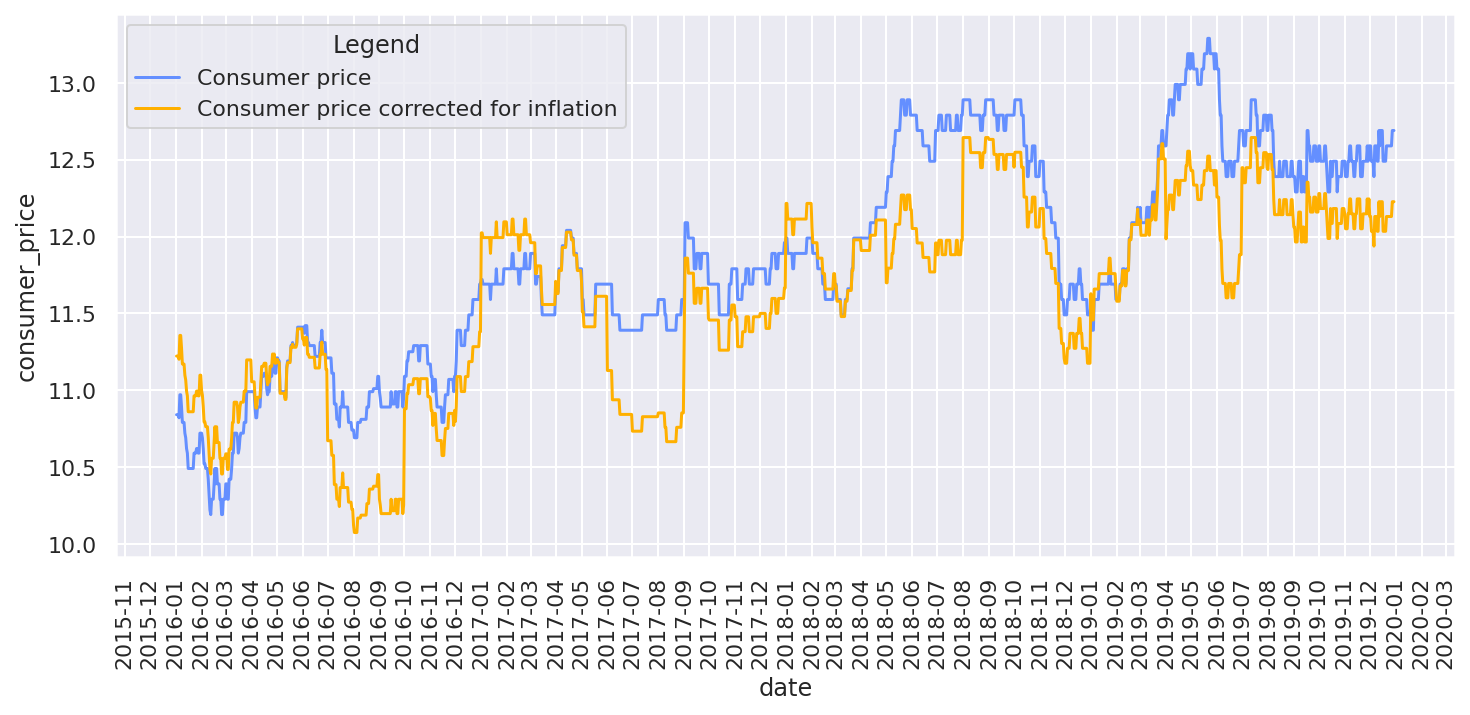

In [14]:
START_DATE = datetime.strptime('01-01-2016', '%d-%m-%Y')
END_DATE = datetime.strptime('31-12-2019', '%d-%m-%Y')
DATA_ERRORS_1 = pd.date_range(datetime.strptime('11-09-2017', '%d-%m-%Y'), datetime.strptime('15-11-2017', '%d-%m-%Y'))
DATA_ERRORS_2 = pd.date_range(datetime.strptime('20-05-2019', '%d-%m-%Y'), datetime.strptime('30-08-2019', '%d-%m-%Y'))
DATA_ERRORS_3 = pd.date_range(datetime.strptime('26-11-2018', '%d-%m-%Y'), datetime.strptime('02-12-2018', '%d-%m-%Y'))

normal = (df_gas['date'] > START_DATE) & (df_gas['date'] < END_DATE)
plt.figure()
sns.lineplot(data=df_gas.loc[normal], x="date", y="consumer_price", color='#648fff')
g = sns.lineplot(data=df_gas.loc[normal], x="date", y="consumer_price_corrected", color='#ffb000')
g.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
plt.legend(title='Legend', loc='upper left', labels=['Consumer price', 'Consumer price corrected for inflation'])
plt.xticks(rotation=90);

[Bevis på at farverne er colorblind safe så Sune bliver glad](https://davidmathlogic.com/colorblind/#%23648FFF-%23FFB000)

In [15]:
df_traffic_sum = df_traffic.pivot_table(index=['date','street','is_public_holiday','is_weekend'], values='traffic_count', aggfunc='sum').reset_index()
df_traffic_sum = df_traffic_sum.dropna()
df_traffic_sum = df_traffic_sum[(df_traffic_sum['traffic_count'] != 0) & (df_traffic_sum['street'] == 'Mellem TSA 1 og 2')]
df_traffic_sum = df_traffic_sum.groupby([df_traffic_sum['date'].dt.date], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'is_public_holiday': 'first', 'is_weekend': 'first'})
df_traffic_sum['date'] = df_traffic_sum['date'].dt.normalize()
df_traffic_sum

date 
 traffic_count 
 is_public_holiday 
 is_weekend 
 
 
 
 
 0 
 2016-01-01 
 21540.0 
 True 
 False 
 
 
 1 
 2016-01-02 
 31160.0 
 False 
 True 
 
 
 2 
 2016-01-03 
 31020.0 
 False 
 True 
 
 
 3 
 2016-01-04 
 49620.0 
 False 
 False 
 
 
 4 
 2016-01-05 
 51543.0 
 False 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2077 
 2022-04-21 
 57263.0 
 False 
 False 
 
 
 2078 
 2022-04-22 
 58840.0 
 False 
 False 
 
 
 2079 
 2022-04-23 
 46654.0 
 False 
 True 
 
 
 2080 
 2022-04-24 
 42882.0 
 False 
 True 
 
 
 2081 
 2022-04-25 
 55410.0 
 False 
 False 
 
 
 
 2082 rows × 4 columns

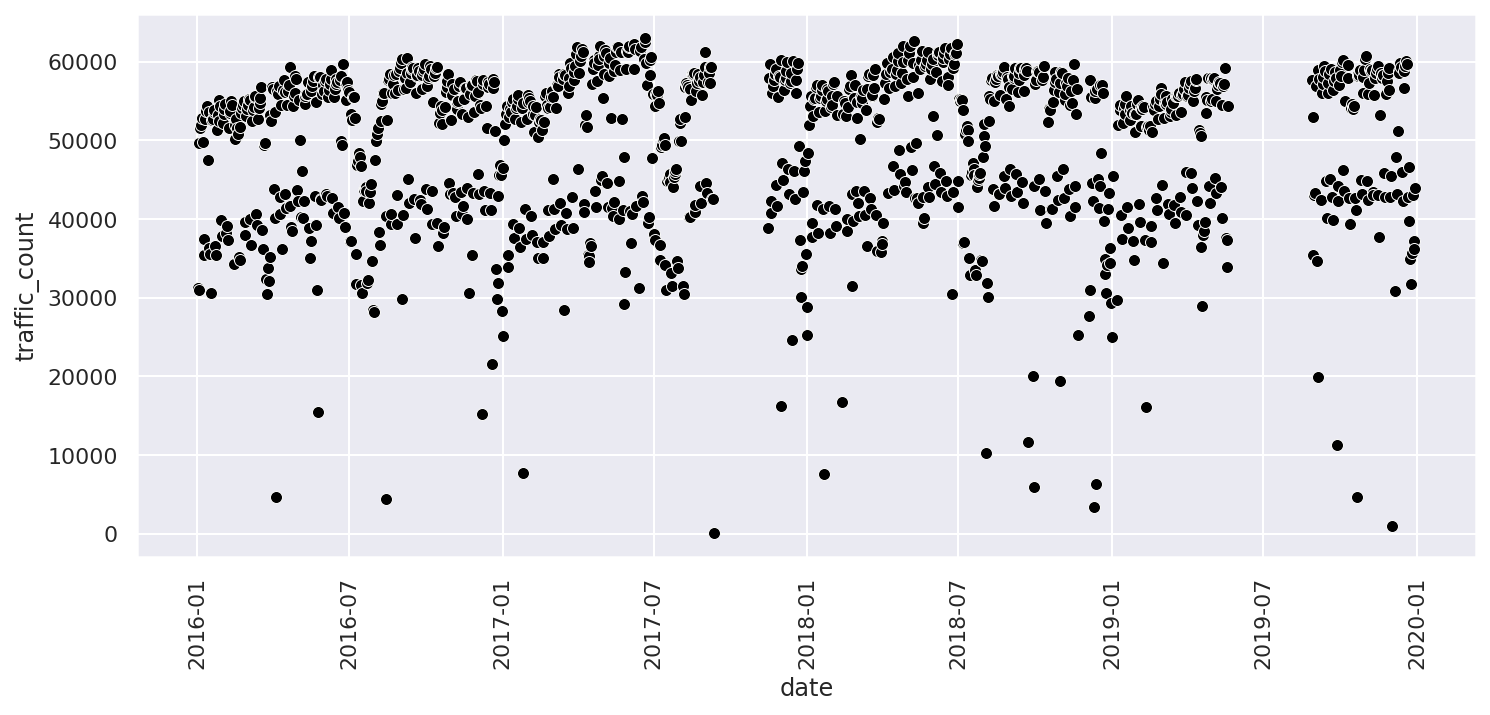

In [16]:
#df_traffic_sum = df_traffic.pivot_table(index='date', values='count', aggfunc='sum').reset_index()
normal = (df_traffic_sum['date'] > START_DATE) & (df_traffic_sum['date'] < END_DATE)

plt.figure()
sns.scatterplot(data=df_traffic_sum.loc[normal], x="date", y="traffic_count", color='black')
plt.xticks(rotation=90);

In [17]:
df_traffic_sum_pretty = df_traffic_sum[df_traffic_sum.date.dt.weekday < 5] # Remove weekends
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(PUBLIC_HOLIDAYS)] # Remove public holidays
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_1)] # Remove data errors
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors
q_low = df_traffic_sum_pretty["traffic_count"].quantile(0.1) # Remove lower quantile

df_traffic_sum_pretty = df_traffic_sum_pretty[(df_traffic_sum["traffic_count"] > q_low)]

<ipython-input-17-0abd30cb5942>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(PUBLIC_HOLIDAYS)] # Remove public holidays
<ipython-input-17-0abd30cb5942>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_1)] # Remove data errors
<ipython-input-17-0abd30cb5942>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
<ipython-input-17-0abd30cb5942>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors
<ipython-input-17-0abd30cb5942>:8: UserWarning: Boolean Series key will be reindexed to match 

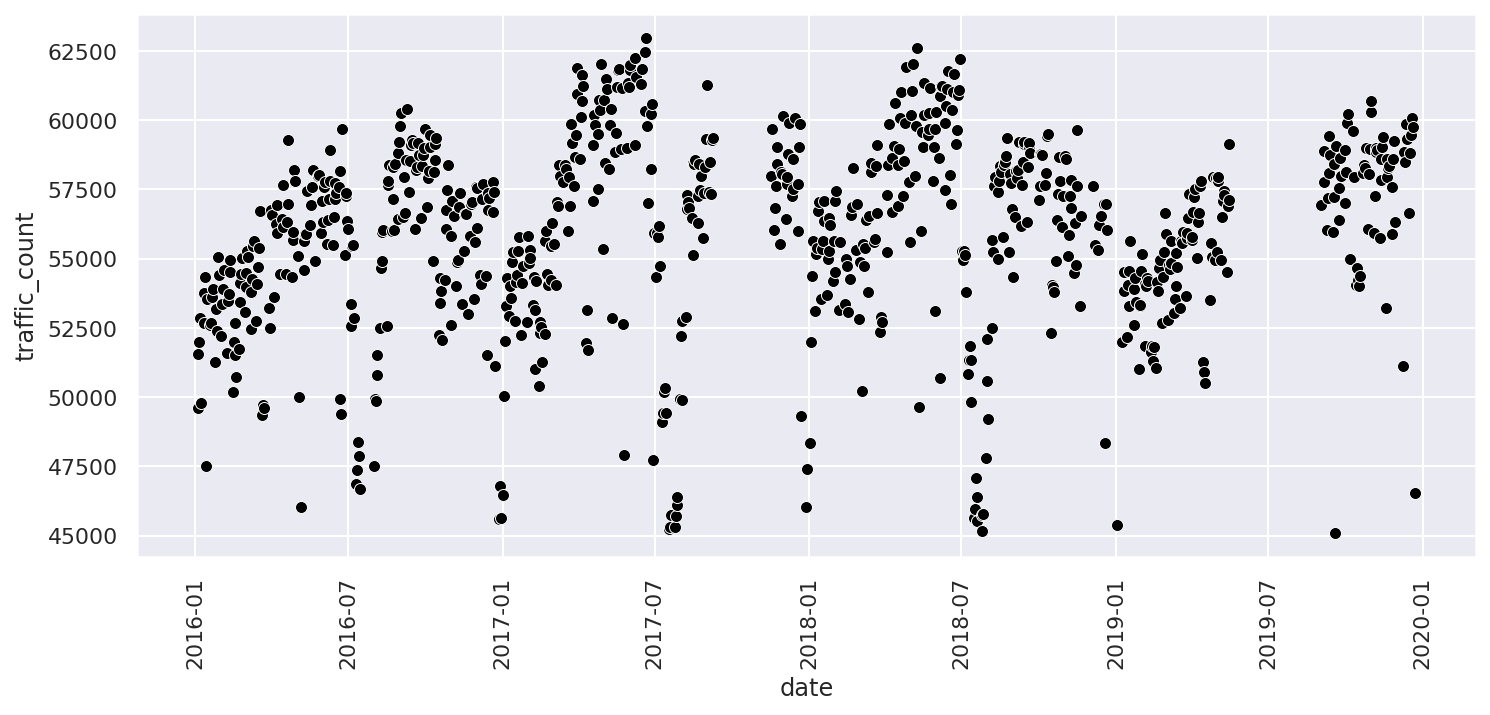

In [18]:
plt.figure()
sns.scatterplot(data=df_traffic_sum_pretty.loc[normal], x="date", y="traffic_count", color='black')
plt.xticks(rotation=90);

# Prediction

Optimizations:
Removed outliers 
one hot encodede months

In [19]:
df_traffic_sum_no_outliers = df_traffic_sum
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_1)] # Remove data errors
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors
q_low = df_traffic_sum_no_outliers["traffic_count"].quantile(0.1) # Remove lower quantile

df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[(df_traffic_sum_no_outliers["traffic_count"] > q_low)]

df_traffic_gas = pd.merge(df_traffic_sum_no_outliers.loc[normal], df_gas, on="date")
df_traffic_gas = df_traffic_gas.loc[:, ["date", "traffic_count", "is_weekend", "is_public_holiday","consumer_price_corrected"]]
df_traffic_gas['month'] = df_traffic_gas['date'].dt.strftime('%m')
one_hot = pd.get_dummies(df_traffic_gas['month'])
# Join the encoded dataframes
df_traffic_gas = df_traffic_gas.join(one_hot)
# Drop columns as it is now encoded
df_traffic_gas.index = df_traffic_gas['date']
df_traffic_gas = df_traffic_gas.drop('date',axis = 1)
df_traffic_gas = df_traffic_gas.drop('month',axis = 1)
df_traffic_gas

<ipython-input-19-0b57edabc90a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
<ipython-input-19-0b57edabc90a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors


traffic_count 
 is_weekend 
 is_public_holiday 
 consumer_price_corrected 
 01 
 02 
 03 
 04 
 05 
 06 
 07 
 08 
 09 
 10 
 11 
 12 
 
 
 date 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2016-01-04 
 49620.0 
 False 
 False 
 11.221690 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 2016-01-05 
 51543.0 
 False 
 False 
 11.200986 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 2016-01-06 
 51992.0 
 False 
 False 
 11.356268 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 2016-01-07 
 52859.0 
 False 
 False 
 11.356268 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 2016-01-08 
 49795.0 
 False 
 False 
 11.273451 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2019-12-23 
 46536.0 
 False 
 False 
 12.130253 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 2019-12-27 
 43090.0 
 False 
 False 
 12.130253 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 2019-12-28 
 37175.0 
 True 
 False 
 12.226601 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 2019-12-29 
 36204.0 
 True 
 False 
 12.226601 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 2019-12-30 
 43977.0 
 False 
 False 
 12.226601 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 
 1126 rows × 16 columns

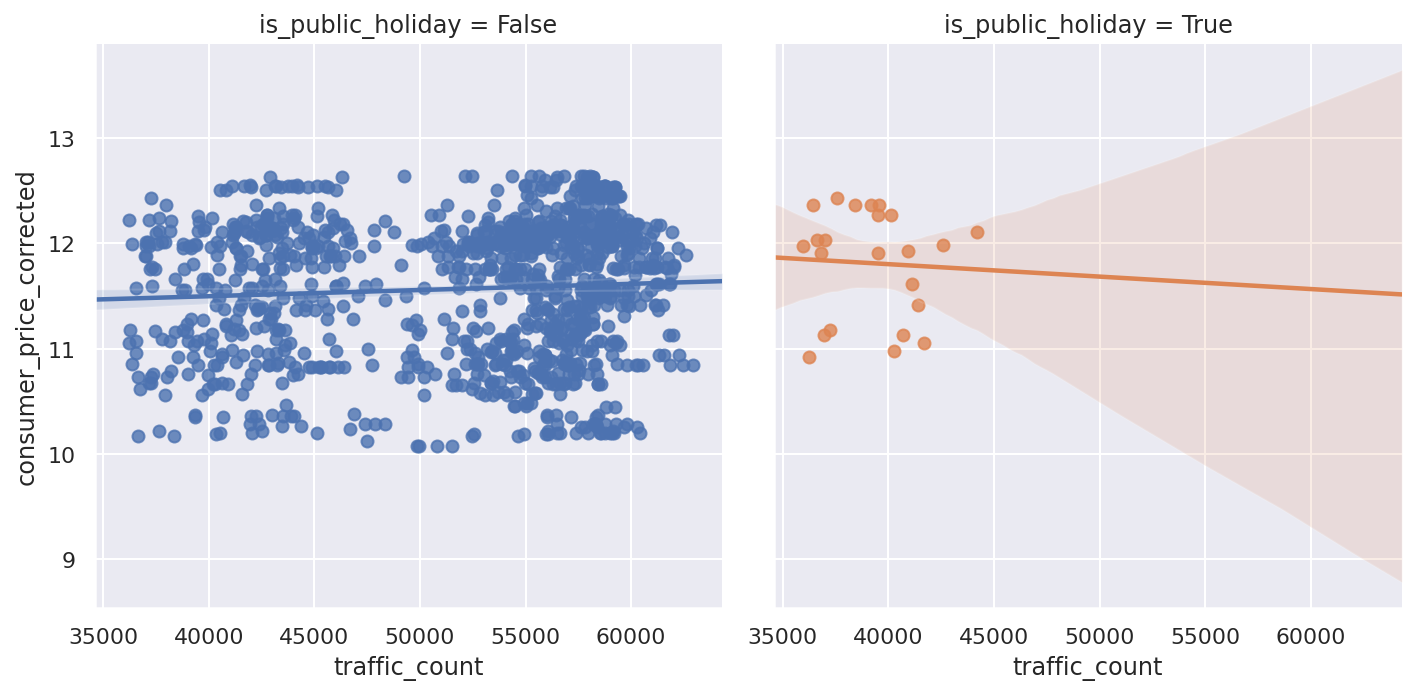

In [20]:
sns.lmplot(x="traffic_count", y="consumer_price_corrected", col="is_weekend", hue="is_weekend", data=df_traffic_gas, truncate=False)
sns.lmplot(x="traffic_count", y="consumer_price_corrected", col="is_public_holiday", hue="is_public_holiday", data=df_traffic_gas, truncate=False)

In [34]:
df_traffic_gas.columns[:4]

Index(['traffic_count', 'is_weekend', 'is_public_holiday',
       'consumer_price_corrected'],
      dtype='object')

In [ ]:
class Baseline:
    def __init__(self):
        self.mean = None

    def fit(self, X, y):
        self.mean = np.mean(y)
    
    def predict(self, X):
        # Check if X is a list of features, or just one feature
        if isinstance(X, list):
            return [self.mean] * len(X[0])
        else:
            return [self.mean] * len(X)

Coefficients: 
 [-13339.12831928 -10132.49284529   1313.99868148]
Intercept: 
 40124.3254930546
Mean squared error: 14958816.85
Coefficient of determination: 0.73
Mean Absolute Error: 2922.5526842289887
Mean Squared Error: 14958816.84844228
Root Mean Squared Error: 3867.662969862069


/opt/python/envs/default/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


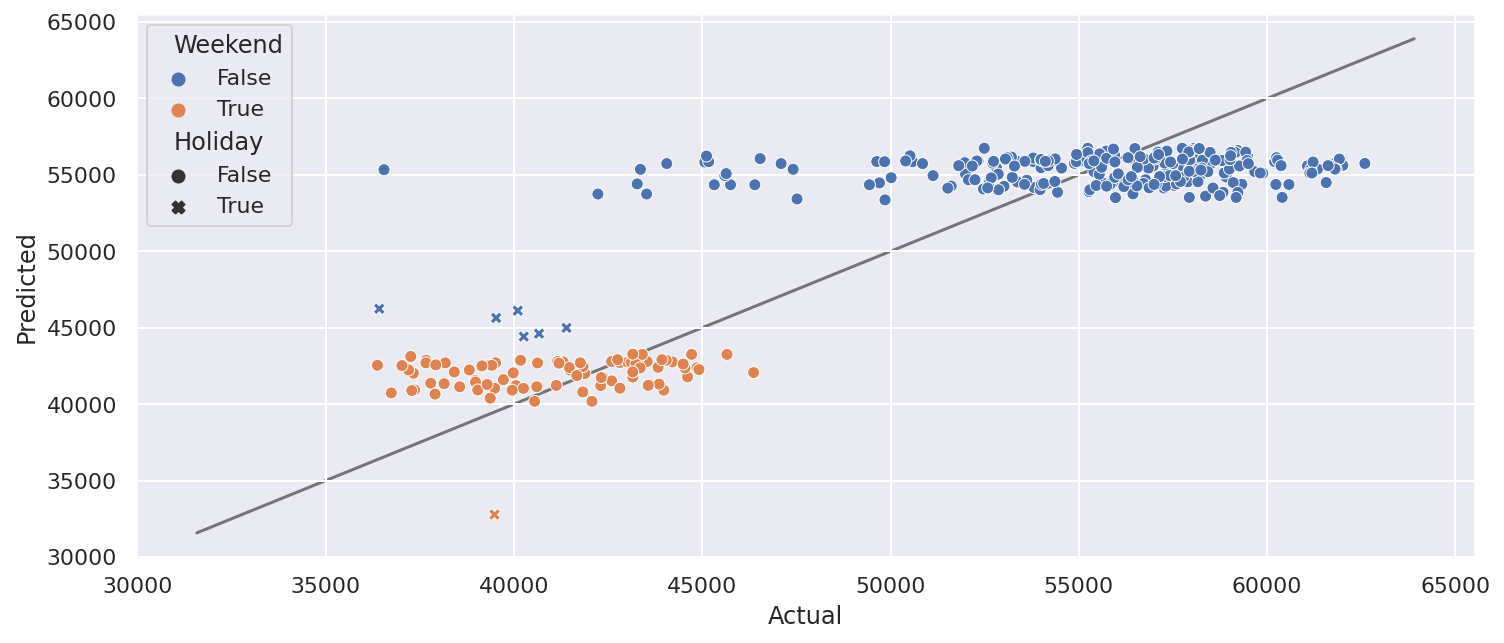

In [56]:
# X is predictors, y is target
target = 'traffic_count'
features = [col for col in df_traffic_gas.columns[:4] if col != target]
X = df_traffic_gas[features]
y = df_traffic_gas[target]

# Split according to a 70%/30% train/test policy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results_df = pd.DataFrame({'actuals': y_train, 'is_weekend': X_train['is_weekend'], 'is_public_holiday': X_train['is_public_holiday']})

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train) # Train the model

lin_y_pred = lin_reg.predict(X_test) # Predict values
results_df["linear_regression"] = lin_reg.predict(X_train)

print("Coefficients: \n", lin_reg.coef_)
print("Intercept: \n", lin_reg.intercept_)
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, lin_y_pred))
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, lin_y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lin_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lin_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lin_y_pred)))

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': lin_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday');

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

Coefficients: 
 [-13767.12936724 -11126.70215189    909.07838235  -2389.57428639
  -2118.92325335    -44.0140335    1358.65301866   1280.60122257
   2616.1838908   -5912.86141881    335.05541238   2376.9899502
   1299.32654028   1284.73091152    -86.16795435]
Intercept: 
 44882.940835029796
Mean squared error: 10993182.35
Coefficient of determination: 0.80
Mean Absolute Error: 2348.0700758412527
Mean Squared Error: 10993182.350002257
Root Mean Squared Error: 3315.5968316431745


/opt/python/envs/default/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


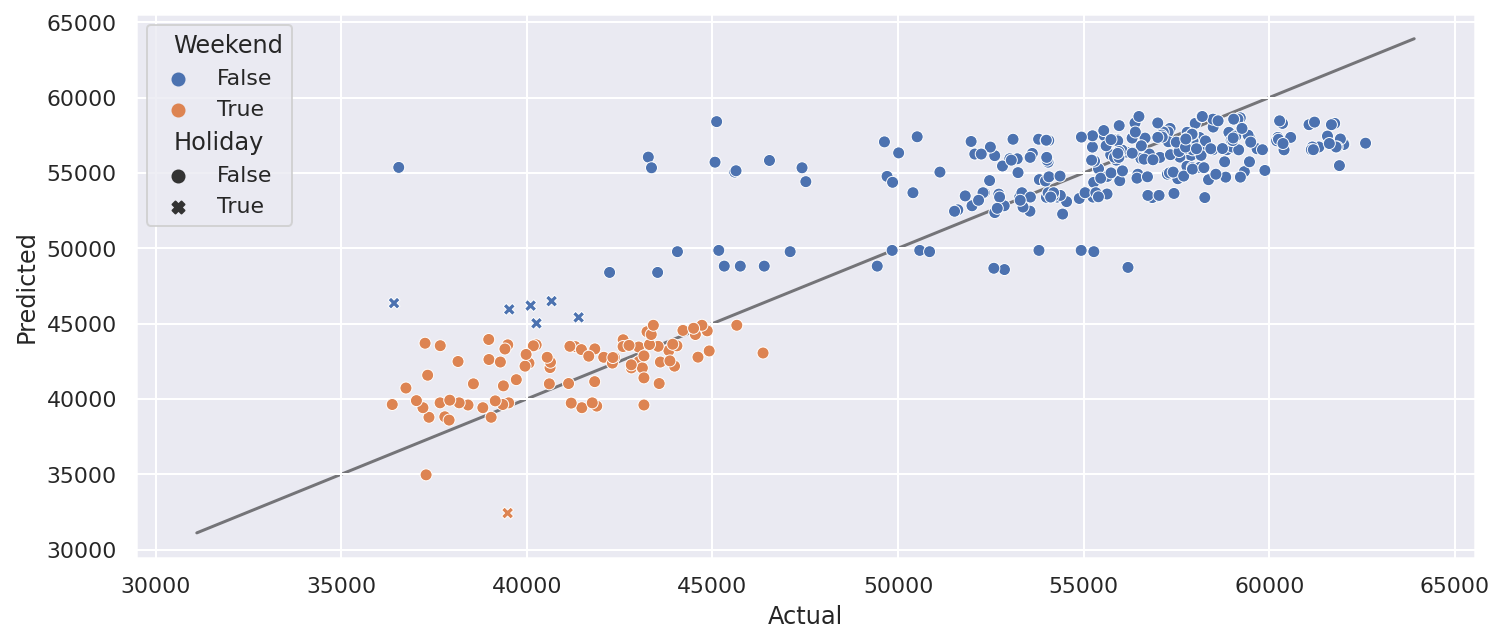

In [63]:
# X is predictors, y is target
target = 'traffic_count'
features = [col for col in df_traffic_gas.columns if col != target]
X = df_traffic_gas[features]
y = df_traffic_gas[target]

# Split according to a 70%/30% train/test policy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train) # Train the model

lin_y_pred = lin_reg.predict(X_test) # Predict values
results_df["linear_regression_features"] = lin_reg.predict(X_train)

print("Coefficients: \n", lin_reg.coef_)
print("Intercept: \n", lin_reg.intercept_)
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, lin_y_pred))
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, lin_y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lin_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lin_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lin_y_pred)))

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': lin_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday');

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

Skriv noget klogt om Lineær
og om at one hot encode måneder

# ANN

Coefficients: 
 [-13767.12936724 -11126.70215189    909.07838235  -2389.57428639
  -2118.92325335    -44.0140335    1358.65301866   1280.60122257
   2616.1838908   -5912.86141881    335.05541238   2376.9899502
   1299.32654028   1284.73091152    -86.16795435]
Intercept: 
 44882.940835029796
Mean squared error: 16905356.14
Coefficient of determination: 0.70
Mean Absolute Error: 3272.2358688658196
Mean Squared Error: 16905356.14433231
Root Mean Squared Error: 4111.612353363618


/opt/python/envs/default/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/python/envs/default/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


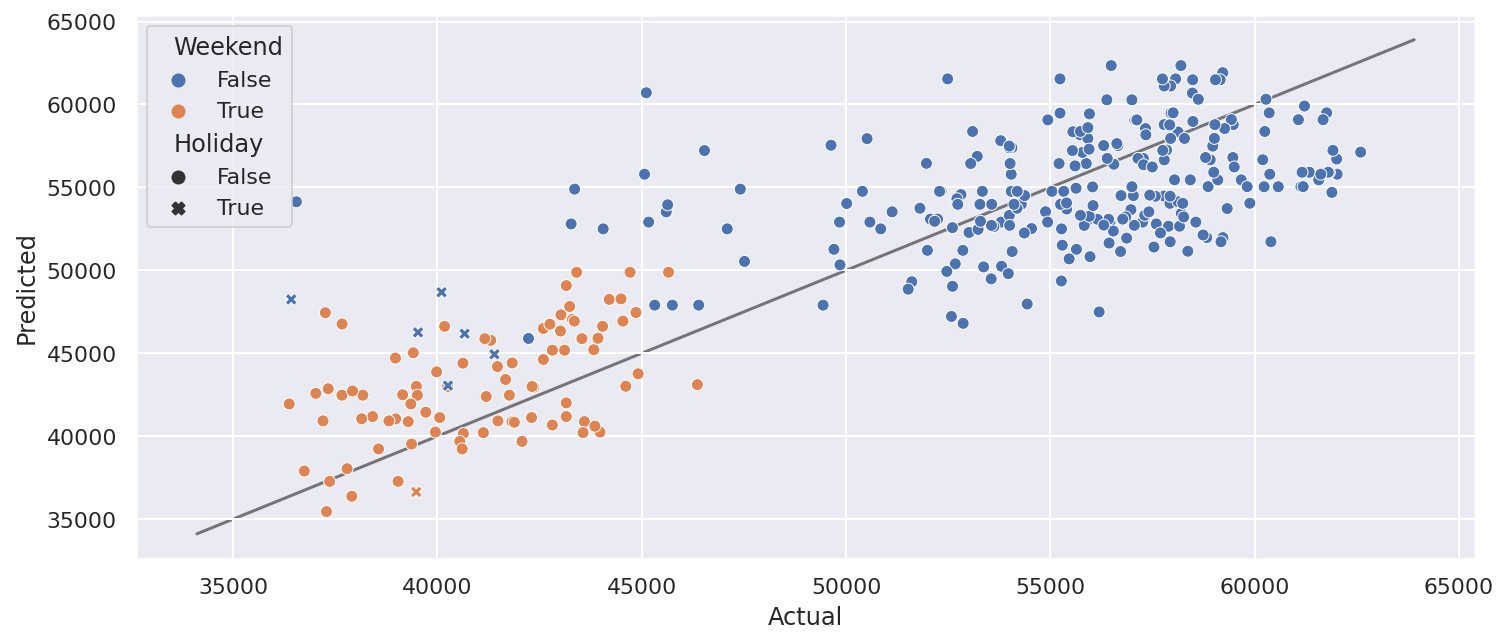

In [64]:
ann_reg = MLPRegressor(hidden_layer_sizes=(150,150,150,150),
                       max_iter = 500, activation='identity'
                       ).fit(X_train, y_train) # Neural network model for regression

#ann_reg.score(X_test, y_test)

ann_y_pred = ann_reg.predict(X_test) # Predict values

results_df["ann"] = ann_reg.predict(X_train)

print("Coefficients: \n", lin_reg.coef_)
print("Intercept: \n", lin_reg.intercept_)
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, ann_y_pred))
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, ann_y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ann_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ann_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ann_y_pred)))

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': ann_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday');
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

# t-test

<ipython-input-76-5f9de95e4ac1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_xticklabels(g1.get_xticklabels(),rotation = 90)
<ipython-input-76-5f9de95e4ac1>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  g2.set_xticklabels(g2.get_xticklabels(),rotation = 90)
<ipython-input-76-5f9de95e4ac1>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g3.set_xticklabels(g3.get_xticklabels(),rotation = 90)
<ipython-input-76-5f9de95e4ac1>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g4.set_xticklabels(g4.get_xticklabels(),rotation = 90)


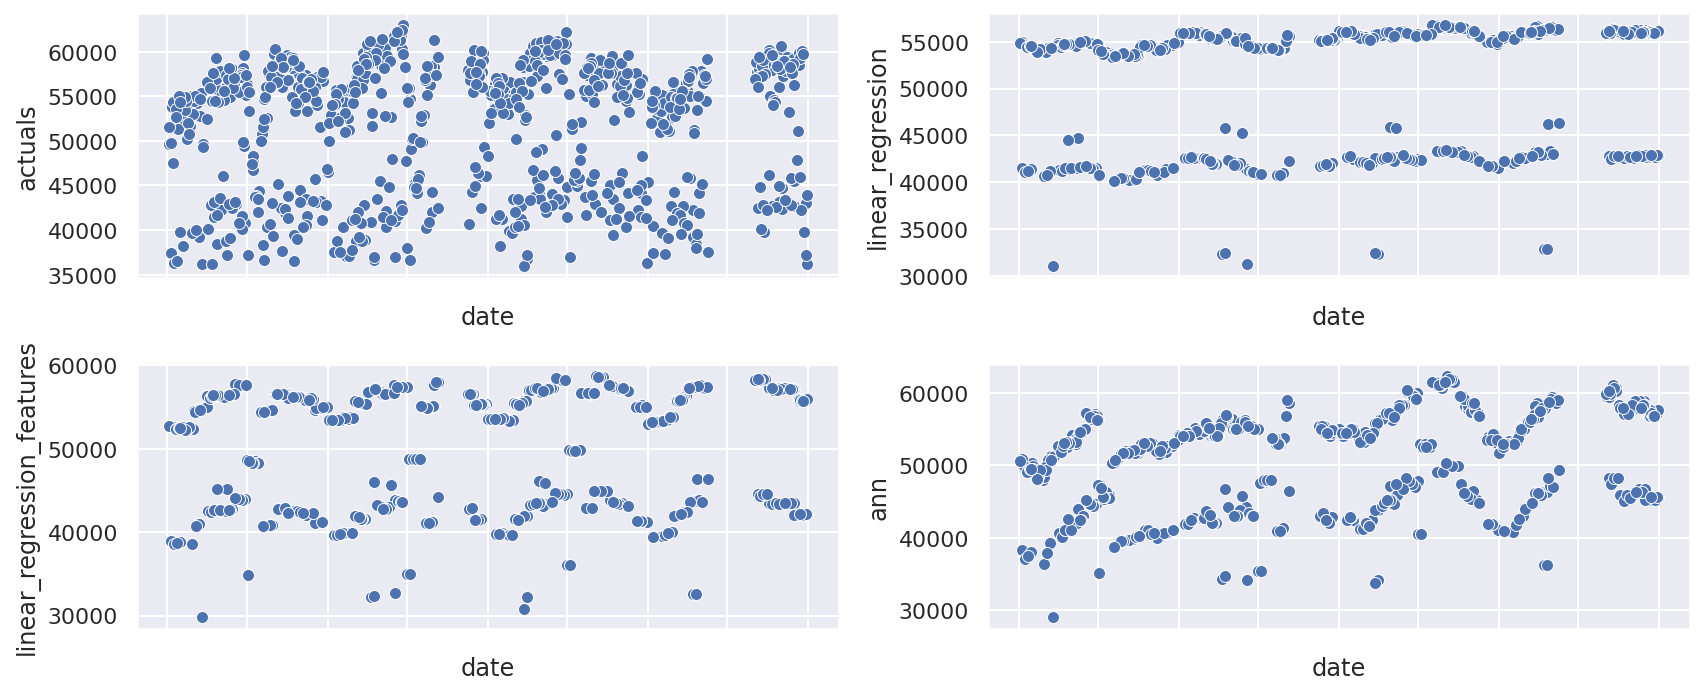

In [76]:
fig, axes = plt.subplots(2,2)
g1 = sns.scatterplot(data=results_df, x='date', y='actuals', ax=axes[0][0])
g2 = sns.scatterplot(data=results_df, x='date', y='linear_regression', ax=axes[0][1])
g3 = sns.scatterplot(data=results_df, x='date', y='linear_regression_features', ax=axes[1][0])
g4 = sns.scatterplot(data=results_df, x='date', y='ann', ax=axes[1][1])
#sns.lmplot(x="date", y="linear_regression_features", hue="is_weekend", data=results_df, truncate=False)
g1.set_xticklabels(g1.get_xticklabels(),rotation = 90)
g2.set_xticklabels(g2.get_xticklabels(),rotation = 90)
g3.set_xticklabels(g3.get_xticklabels(),rotation = 90)
g4.set_xticklabels(g4.get_xticklabels(),rotation = 90)

plt.tight_layout()
#plt.legend(title='Legend', loc='lower left', labels=['Actual traffic count', 'Linear regression prediction (no features)', 'Linear regression prediction (with features)', 'Artificial neural network prediction']);

# Results
positive correlation cause of increased cars

# References

- [COVID-19 time line](http://thinkeuropa.dk/politik/tidslinje-over-coronakrisen-hvad-skete-der-og-hvornaar)
- [Consumer price index on gas](https://www.dst.dk/da/Statistik/emner/oekonomi/prisindeks/forbrugerprisindeks?tab=dok)
- [Encoding time](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)

# Traffic/Covid Analysis

# Traffic during COVID (2020-2021) (Whomas Titting)
**Introductory text**

bla bla bla

### General patterns of traffic data
**Explanatory text**

Plot 1: Timeline plot of traffic counts with labeled highlights (maybe aggrevated, maybe for each location)

Plot 2: Traffic count distribution based on weekday/month

In [56]:
REF_YEARS = {'Mellem TSA 1 og 2': 2018, 'Tagensvej ml. Ægirsgade og Hermodsgade': 2017, 'Strandvejen ud for nr. 79': 2021}
streets = df_traffic['street'].unique()

df_day_ref = df_traffic.groupby([df_traffic['date'].dt.dayofyear, df_traffic['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})

ref_a = (df_traffic['street'] == 'Mellem TSA 1 og 2') & (df_traffic['date'].dt.year == 2018)
ref_b = (df_traffic['street'] == 'Tagensvej ml. Ægirsgade og Hermodsgade') & (df_traffic['date'].dt.year == 2017)
ref_c = (df_traffic['street'] == 'Strandvejen ud for nr. 79') & (df_traffic['date'].dt.year == 2021)
refs = [ref_a, ref_b, ref_c]

<ipython-input-57-ea5e5783ec47>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
<ipython-input-57-ea5e5783ec47>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
<ipython-input-57-ea5e5783ec47>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)


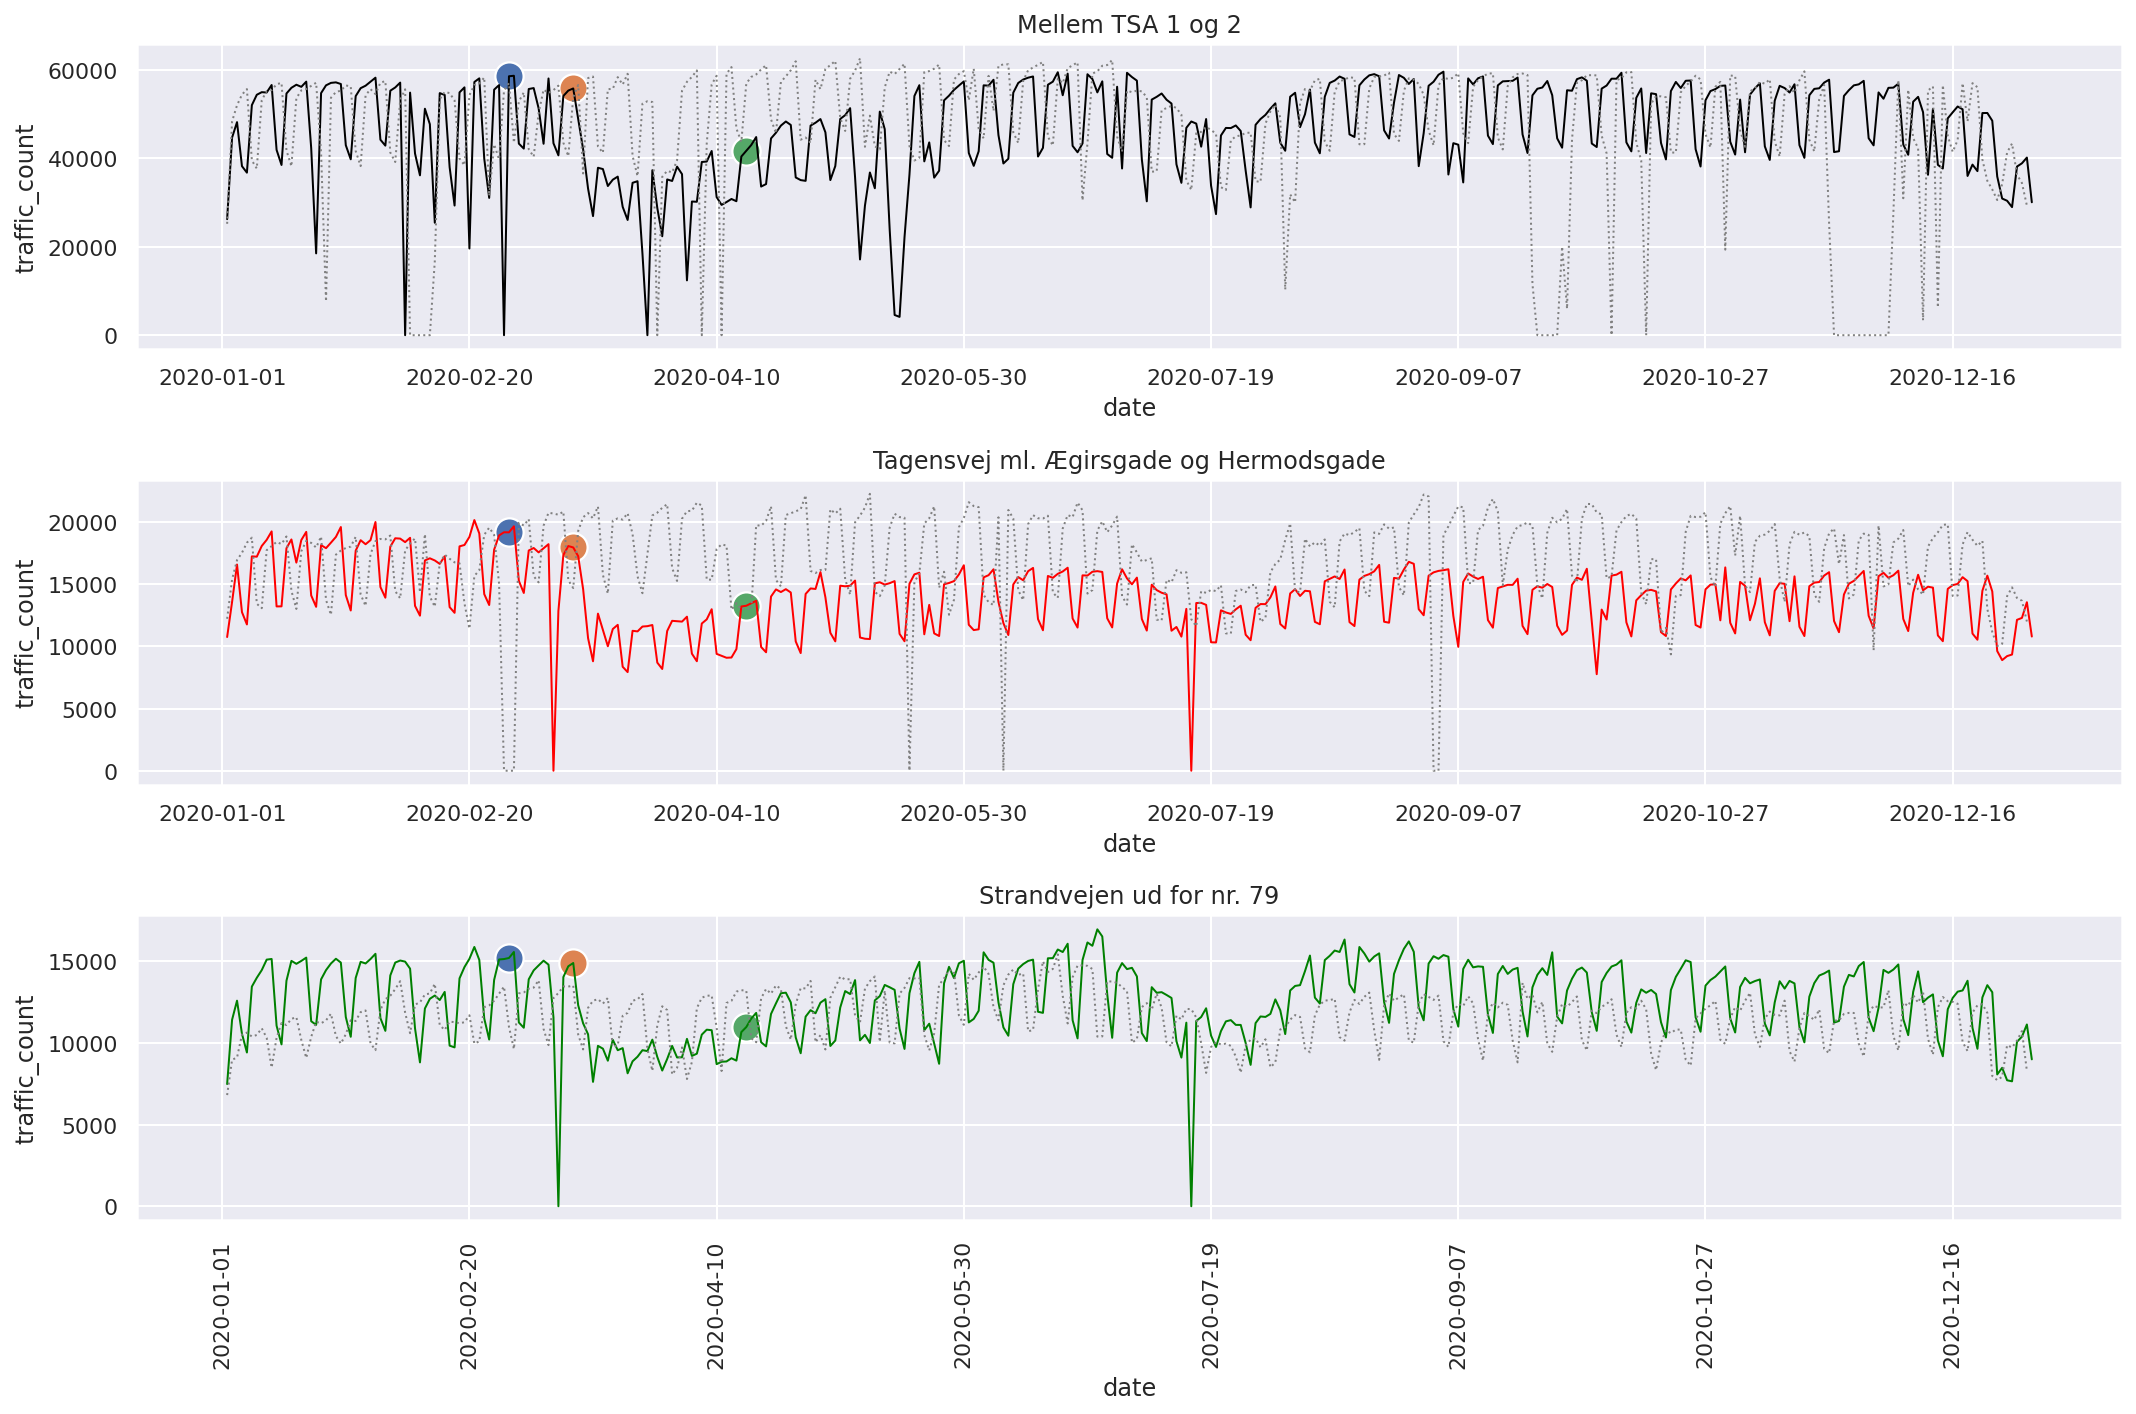

In [57]:
# Code here
streets = df_traffic['street'].unique()
df_day = df_traffic.groupby([df_traffic['date'].dt.date, df_traffic['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})
df_day_2020 = df_day.loc[df_day['date'].dt.year == 2020]

fig, axes = plt.subplots(3, 1, figsize=(15,10))
colors = ['black', 'red', 'green']
for i, (color, street, ref) in enumerate(zip(colors, streets, refs)):

    df_day_2020_street = df_day_2020.loc[df_day_2020['street'] == street]
    g = sns.lineplot(x=df_day_2020_street['date'].dt.dayofyear, y=df_day_2020_street['traffic_count'], color=color, linewidth=1, ax=axes[i])
    for date in COVID_DATES:
        sns.scatterplot(x=[date.timetuple().tm_yday], y=df_day_2020_street.loc[df_day_2020_street['date'] == date]['traffic_count'], s=200, ax=axes[i])
    
    df_day_ref = df_traffic.loc[ref]
    df_day_2020_street_ref = df_day_ref.groupby([df_day_ref['date'].dt.dayofyear], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})
    g = sns.lineplot(x=df_day_2020_street_ref['date'].dt.dayofyear, y=df_day_2020_street_ref['traffic_count'], color='grey', linestyle='dotted', linewidth=1, ax=axes[i])

    xlabels = [datetime.strptime('20' + str(int(x+1)).zfill(3), '%y%j').date() if 0 <= x <= 370 else datetime.strptime('18001', '%y%j').date() for x in g.get_xticks()]
    g.set_xticklabels(xlabels)
    g.set_title(street)
    #g.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))
    
plt.xticks(rotation=90)
plt.tight_layout()

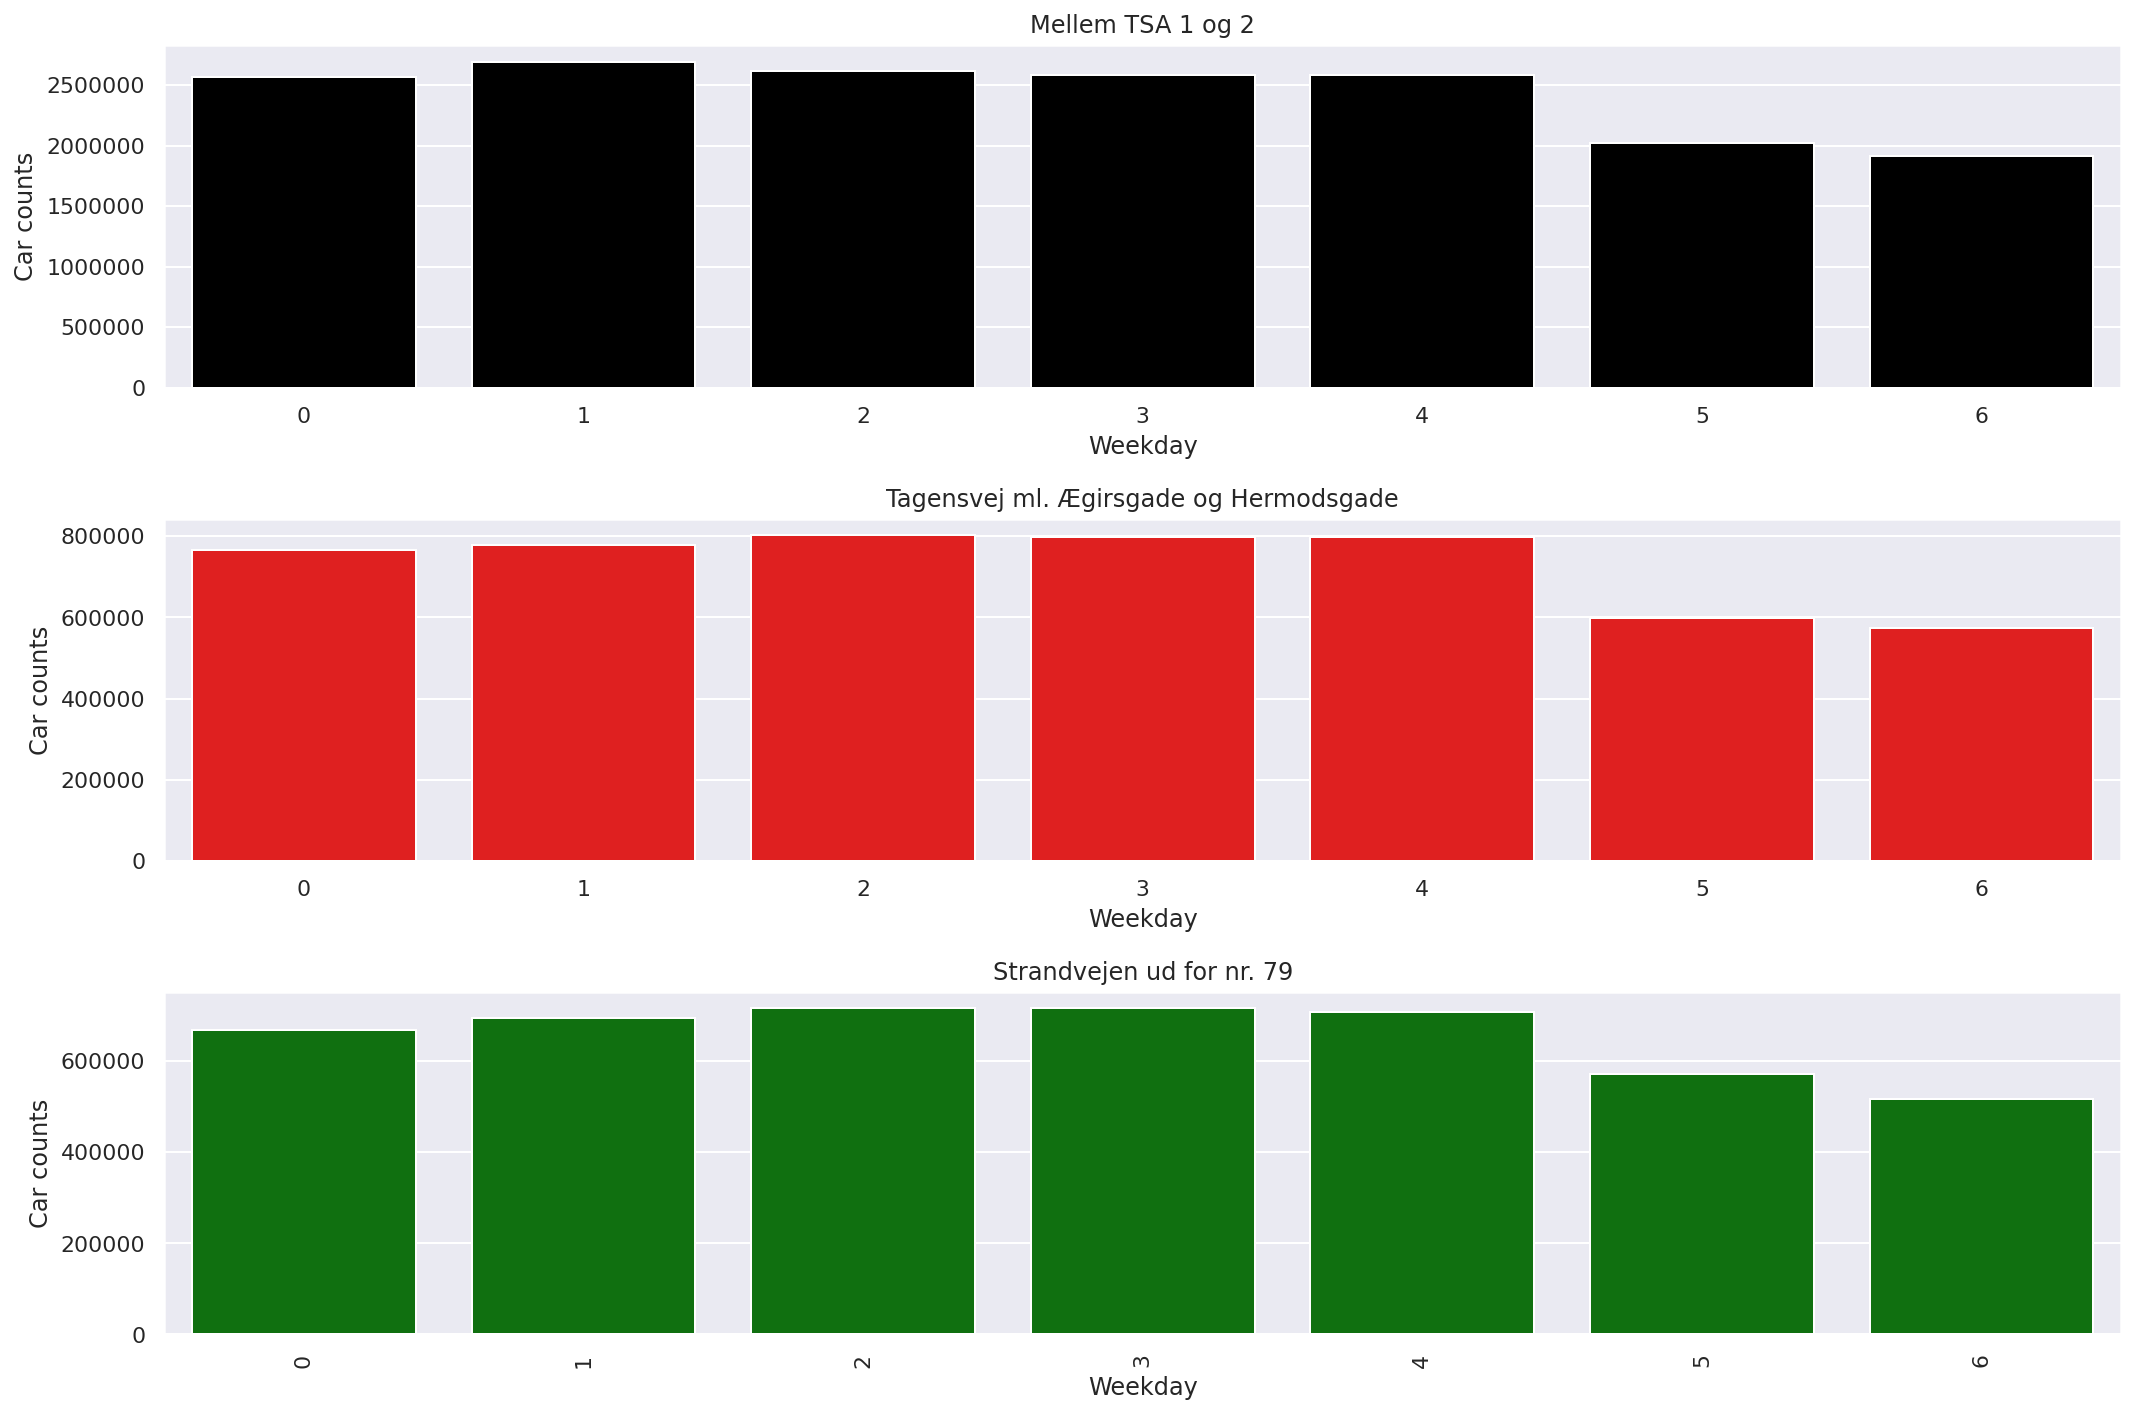

In [58]:
df_dayofweek_2020 = df_traffic.loc[df_traffic['date'].dt.year == 2020]
temp = pd.DatetimeIndex(df_dayofweek_2020['date'])
df_dayofweek_2020['weekday'] = temp.weekday


df_dayofweek_2020 = df_dayofweek_2020.groupby([df_dayofweek_2020['weekday'], df_dayofweek_2020['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})

fig, axes = plt.subplots(3, 1, figsize=(15,10))
colors = ['black', 'red', 'green']
for i, (color, street) in enumerate(zip(colors, streets)):
    df_dayofweek_2020_street = df_dayofweek_2020.loc[df_dayofweek_2020['street'] == street]
    g = sns.barplot(data=df_dayofweek_2020_street, x='weekday', y='traffic_count', color=color, linewidth=1, ax=axes[i])
    g.set_title(street) 
    g.set_xlabel('Weekday')
    g.set_ylabel('Car counts')
    g.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=90);
plt.tight_layout()

### General patterns of COVID data
**Explanatory text**

Plot 1: Timeline plot of COVID cases/deaths/tests with labeled highlights
Plot 2: Copenhagen specific COVID plot

In [59]:
# Code here
columns = ['municipality', 'date', 'cases']
df_covid = pd.read_csv('07_bekraeftede_tilfaelde_pr_dag_pr_kommune.csv', usecols=['Kommunenavn', 'Dato', 'Bekræftede tilfælde i alt'], sep=';', encoding='latin-1')
df_covid.columns = columns
df_covid['date'] = pd.to_datetime(df_covid['date'])
df_covid = df_covid.loc[df_covid['date'].dt.year == 2020]
df_covid = df_covid.groupby([df_covid['date'].dt.date], as_index=False).agg({'date': 'first', 'cases': 'sum'})

In [60]:
# Code here
columns = ['date', 'hospitalizations']
df_hospitalizations = pd.read_csv('05_nye_indlaeggelser_pr_dag.csv', sep=';', encoding='latin-1')
df_hospitalizations.columns = columns
df_hospitalizations['date'] = pd.to_datetime(df_hospitalizations['date'])
df_hospitalizations = df_hospitalizations.loc[df_hospitalizations['date'].dt.year == 2020]

df_covid = pd.merge(df_covid, df_hospitalizations, on="date")

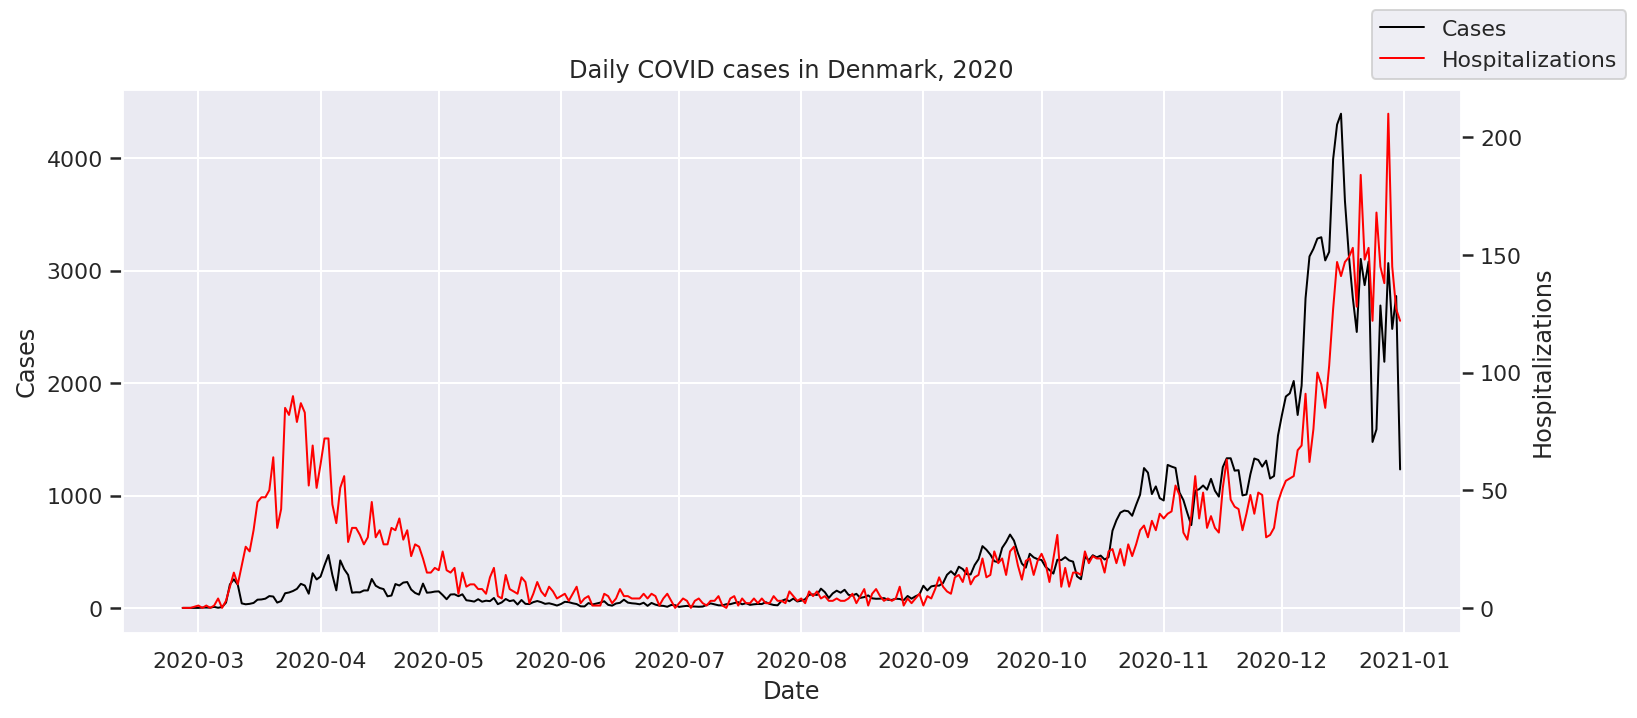

In [61]:
fig = plt.figure()

g1 = sns.lineplot(data=df_covid, x='date', y='cases', color='black', linewidth=1, legend=False)
ax2 = plt.twinx()
ax2.grid(False)
g2 = sns.lineplot(data=df_covid, x='date', y='hospitalizations', color='red', linewidth=1, legend=False)
g1.set_title('Daily COVID cases in Denmark, 2020')
g1.set_xlabel('Date')
g1.set_ylabel('Cases')
g2.set_ylabel('Hospitalizations')

fig.legend(['Cases' , 'Hospitalizations'], loc=1);

### Linking traffic to COVID
**Explanatory text**

Ideas:
- Comparing difference in means/peaks/lows
- Duration of peaks/lows
- Time of peaks/lows
- Impact of new restrictions/reopenings

Plot ideas:
- Show the difference when comparing with a normal year (i.e. bar plot where a bar is positive if more cars are counted than the reference year, and negative if fewer cars are counted)
- 

In [62]:
# Code here
df_tc = pd.merge(df_covid, df_day_2020, on='date')
#df_tc = df_day_2020

<ipython-input-63-d04beb18b111>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
<ipython-input-63-d04beb18b111>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
<ipython-input-63-d04beb18b111>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)


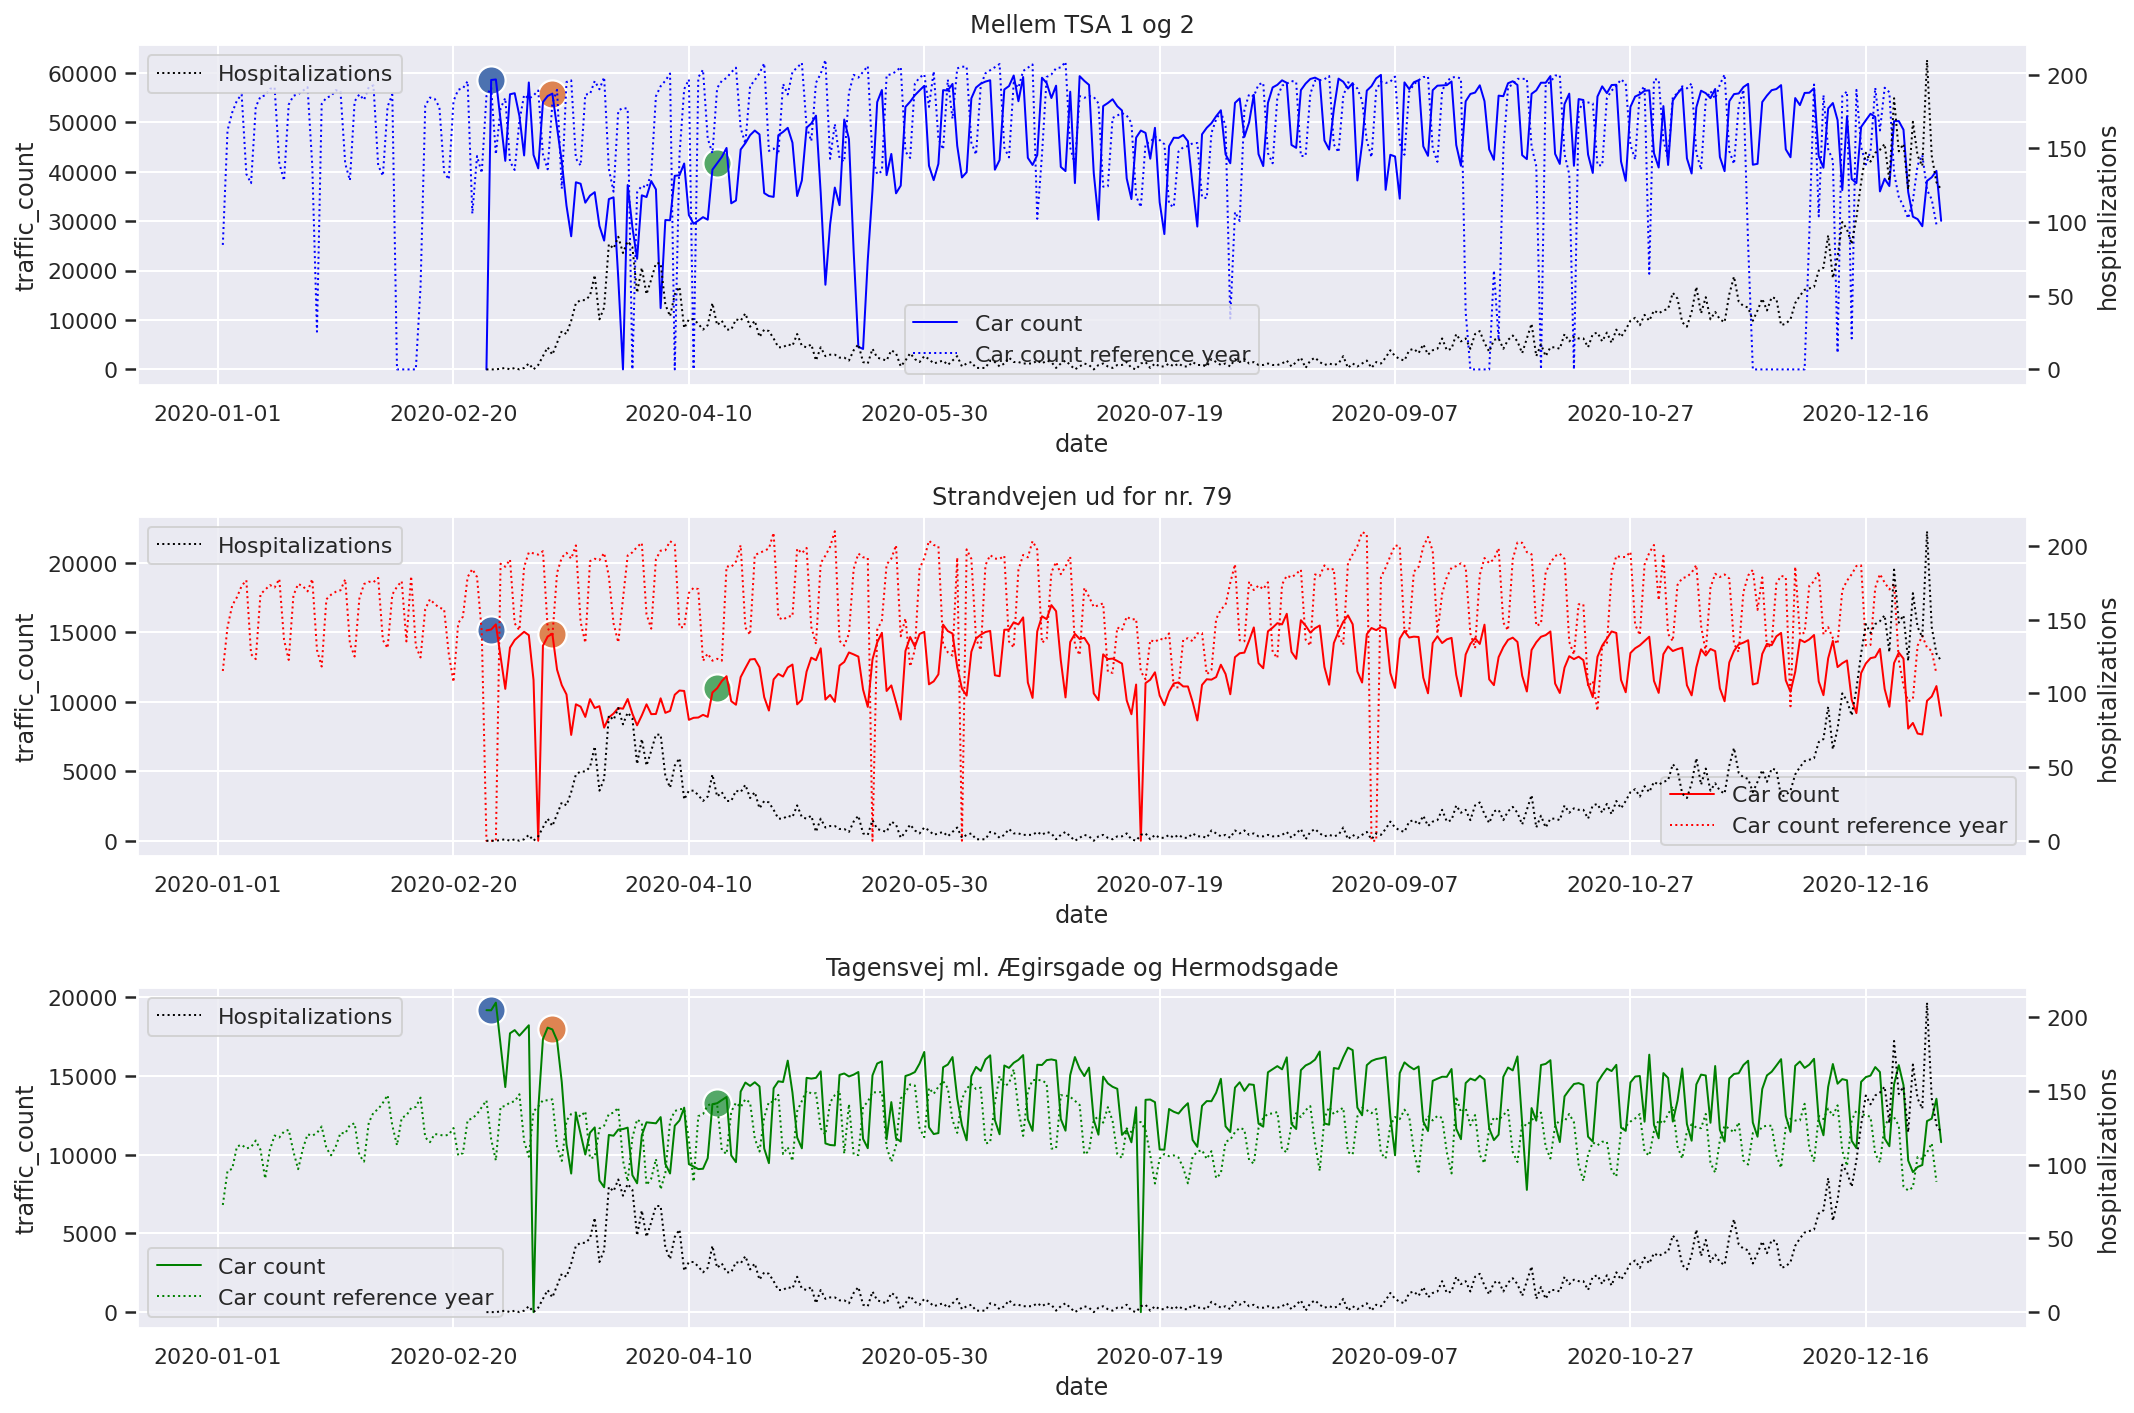

In [63]:
# Code here
streets = df_tc['street'].unique()
df_tc_week = df_tc.groupby([df_tc['date'].dt.dayofyear, df_tc['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'cases': 'sum', 'hospitalizations': 'sum', 'direction': 'first'})
fig, axes = plt.subplots(3, 1, figsize=(15,10))
colors = ['blue', 'red', 'green']
a = None
for i, (color, street, ref) in enumerate(zip(colors, streets, refs)):
    df_day_2020_street = df_tc_week.loc[df_tc_week['street'] == street]
    g = sns.lineplot(x=df_day_2020_street['date'].dt.dayofyear, y=df_day_2020_street['traffic_count'], color=color, linewidth=1, ax=axes[i], label='Car count')
    
    df_day_ref = df_traffic.loc[ref]
    df_day_2020_street_ref = df_day_ref.groupby([df_day_ref['date'].dt.dayofyear], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})
    g = sns.lineplot(x=df_day_2020_street_ref['date'].dt.dayofyear, y=df_day_2020_street_ref['traffic_count'], color=color, linestyle='dotted', linewidth=1, ax=axes[i], label='Car count reference year')

    xlabels = [datetime.strptime('20' + str(int(x+1)).zfill(3), '%y%j').date() if 0 <= x <= 370 else datetime.strptime('18001', '%y%j').date() for x in g.get_xticks()]
    g.set_xticklabels(xlabels)
 
    g.set_title(street)
    #g.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))    
    for date in COVID_DATES:
        sns.scatterplot(x=[date.timetuple().tm_yday], y=df_day_2020_street.loc[df_day_2020_street['date'] == date]['traffic_count'], s=200, ax=axes[i])
       
    ax2 = axes[i].twinx()
    sns.lineplot(x=df_day_2020_street['date'].dt.dayofyear, y=df_day_2020_street['hospitalizations'], color='black', linewidth=1, label='Hospitalizations', linestyle='dotted')
    ax2.grid(False)
    axes[i].set_axisbelow(True)
    
plt.xticks(rotation=90)
plt.tight_layout()

2101.0


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


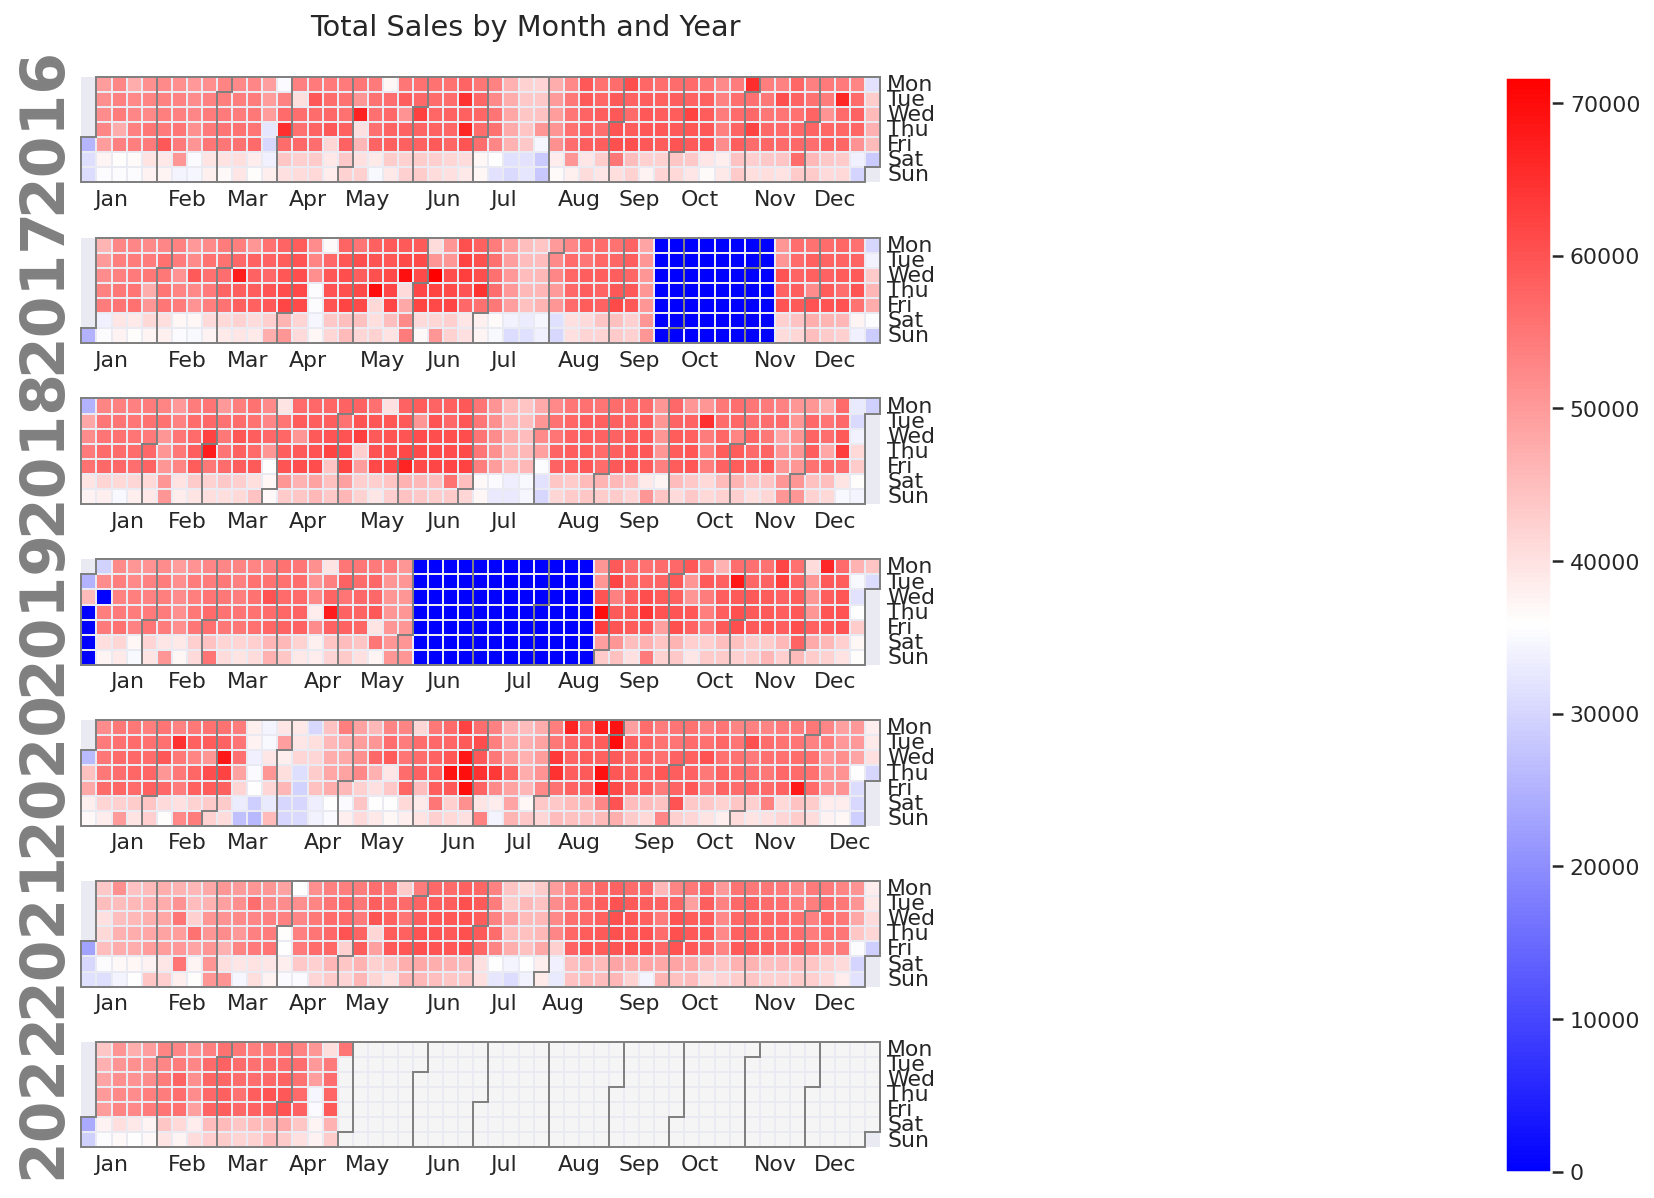

In [64]:
df_ = df_traffic
df_ = df_.loc[df_['street'] == 'Mellem TSA 1 og 2']
df_['traffic_count'] = df_['traffic_count'].replace(0,df_['traffic_count'].median())
df_['traffic_count'] = df_['traffic_count'].replace(np.nan,df_['traffic_count'].median())
median = df_['traffic_count'].median()
#df_ = df_.loc[df_['date'].dt.year == 2022]
df_ = df_.set_index('date')
print(median)
pl1 = calplot.calplot(data = df_['traffic_count'],how = 'sum', cmap = 'bwr', figsize = (16, 8), suptitle = "Total Sales by Month and Year")

In [65]:
df_traffic.head()

date 
 traffic_count 
 street 
 direction 
 is_public_holiday 
 is_weekend 
 coordinates 
 
 
 
 
 96 
 2016-01-01 00:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 96 
 2016-01-01 00:00:00 
 511.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 97 
 2016-01-01 01:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 97 
 2016-01-01 01:00:00 
 681.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 98 
 2016-01-01 02:00:00 
 1205.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424]

In [66]:
df_tc['traffic_count'].corr(df_tc['hospitalizations'])

-0.07104798113408582

# Traffic/Covid Analysis Report

# Traffic during COVID (2020) (Thomas Witting)
**Introductory text explaining overall method and purpose of this section**

### Data Preparation

Read and prepare dataframe containing related traffic and COVID features.

In [27]:
#### Combine traffic and COVID related into single dataframe, containing data for 2020 on a daily basis ####
# Get traffic on a daily basis for 2020
df_traffic_day = df_traffic.groupby([df_traffic['date'].dt.date, df_traffic['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum'})
df_traffic_2020 = df_traffic_day.loc[df_traffic_day['date'].dt.year == 2020]

# Get reference data for traffic for each street
ref_a = (df_traffic['street'] == 'Mellem TSA 1 og 2') & (df_traffic['date'].dt.year == 2018)
ref_b = (df_traffic['street'] == 'Tagensvej ml. Ægirsgade og Hermodsgade') & (df_traffic['date'].dt.year == 2017)
ref_c = (df_traffic['street'] == 'Strandvejen ud for nr. 79') & (df_traffic['date'].dt.year == 2021)

df_ref = df_traffic.loc[ref_a | ref_b | ref_c]
df_ref_day = df_ref.groupby([df_ref['date'].dt.dayofyear, df_ref['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum'})
df_ref_day['date'] = df_ref_day['date'].apply(lambda x: x.replace(year = 2020))
df_ref_day = df_ref_day.rename(columns={'traffic_count': 'traffic_count_ref'})

df_traffic_2020 = pd.merge(df_traffic_2020, df_ref_day, how='left', left_on=['date','street'], right_on=['date','street'],)





# Get COVID cases data on a daily basis
columns = ['municipality', 'date', 'cases']
df_cases = pd.read_csv('07_bekraeftede_tilfaelde_pr_dag_pr_kommune.csv', usecols=['Kommunenavn', 'Dato', 'Bekræftede tilfælde i alt'], sep=';', encoding='latin-1')
df_cases.columns = columns
df_cases['date'] = pd.to_datetime(df_cases['date'])
df_cases = df_cases.loc[df_cases['date'].dt.year == 2020]
df_cases = df_cases.groupby([df_cases['date'].dt.date], as_index=False).agg({'date': 'first', 'cases': 'sum'})

# Get COVID hospitalizations data on a daily basis
columns = ['date', 'hospitalizations']
df_hospitalizations = pd.read_csv('05_nye_indlaeggelser_pr_dag.csv', sep=';', encoding='latin-1')
df_hospitalizations.columns = columns
df_hospitalizations['date'] = pd.to_datetime(df_hospitalizations['date'])
df_hospitalizations = df_hospitalizations.loc[df_hospitalizations['date'].dt.year == 2020]

# Collect COVID related data to single dataframe
df_covid = pd.merge(df_cases, df_hospitalizations, on="date")

# Merge traffic data with COVID data
df_tc = pd.merge(df_covid, df_traffic_2020, on='date', how='right').fillna(0)

# Unique streets
streets = df_tc['street'].unique()

### Getting to know the data
**Plot basic distribution etc**

**Histograms**

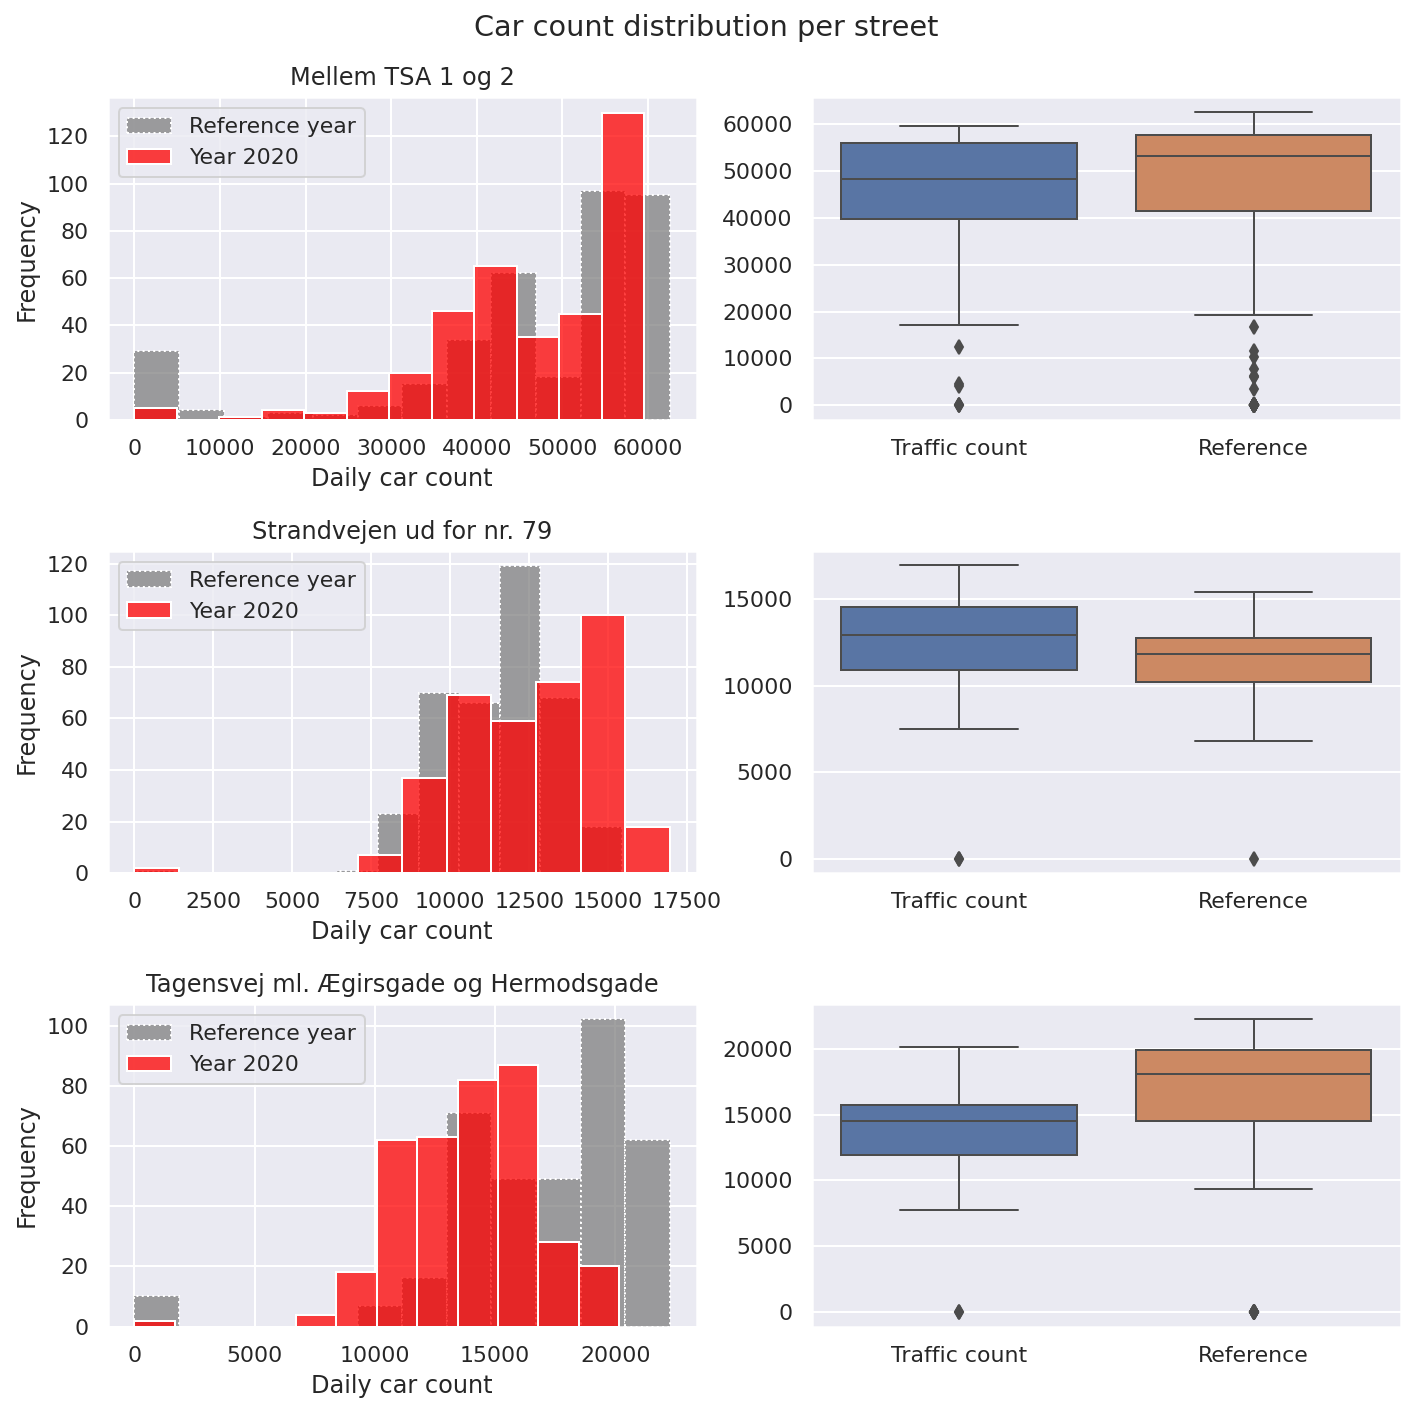

In [28]:
# Traffic count histograms
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i, street in enumerate(streets):
    df_tc_street = df_tc.loc[df_tc['street'] == street]
    g = sns.histplot(x=df_tc_street['traffic_count_ref'], color='grey', bins=12, linestyle='dotted', linewidth=1, ax=axes[i][0], label='Reference data')
    g = sns.histplot(x=df_tc_street['traffic_count'], color='red', bins=12, linewidth=1, ax=axes[i][0], label='Car count')

    d = {'Traffic count': df_tc_street['traffic_count'], 'Reference': df_tc_street['traffic_count_ref']}
    g2 = sns.boxplot(data=list(d.values()), linewidth=1, ax=axes[i][1])
    g2.set_xticklabels(['Traffic count', 'Reference'])

    g.set_title(street)
    g.set_xlabel('Daily car count')
    g.set_ylabel('Frequency')
    axes[i][0].legend(['Reference year', 'Year 2020'])

fig.suptitle('Car count distribution per street')
plt.tight_layout()

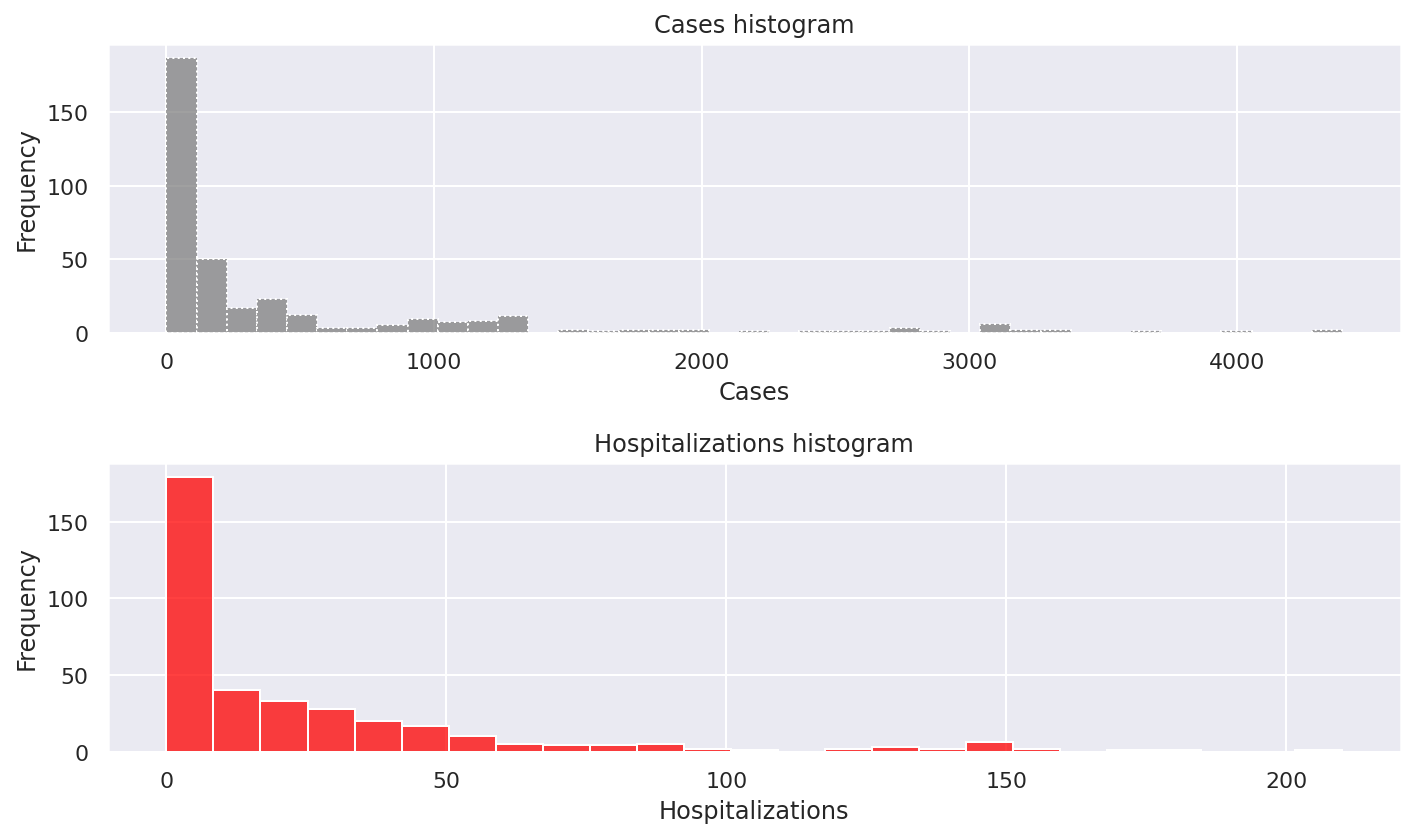

In [29]:
# COVID cases, hospitalizations histograms
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

g1 = sns.histplot(x=df_tc_street['cases'], color='grey', linestyle='dotted', linewidth=1, ax=axes[0], label='Reference data')
g2 = sns.histplot(x=df_tc_street['hospitalizations'], color='red', linewidth=1, ax=axes[1], label='Car count')

g1.set_title('Cases histogram')
g1.set_xlabel('Cases')
g1.set_ylabel('Frequency')

g2.set_title('Hospitalizations histogram')
g2.set_xlabel('Hospitalizations')
g2.set_ylabel('Frequency')

plt.tight_layout()

**Timeline overview plot**

Investigating a timeline plot for each street during the year of 2020 and comparing it with traffic counts from a reference year, some patterns are already visible. For all three streets, they follow a near-identical pattern with the reference year during January and February, while they all deviate significantly at the start of March – coinciding with the onset of COVID in Denmark. During the following months, the traffic seems to climb back 

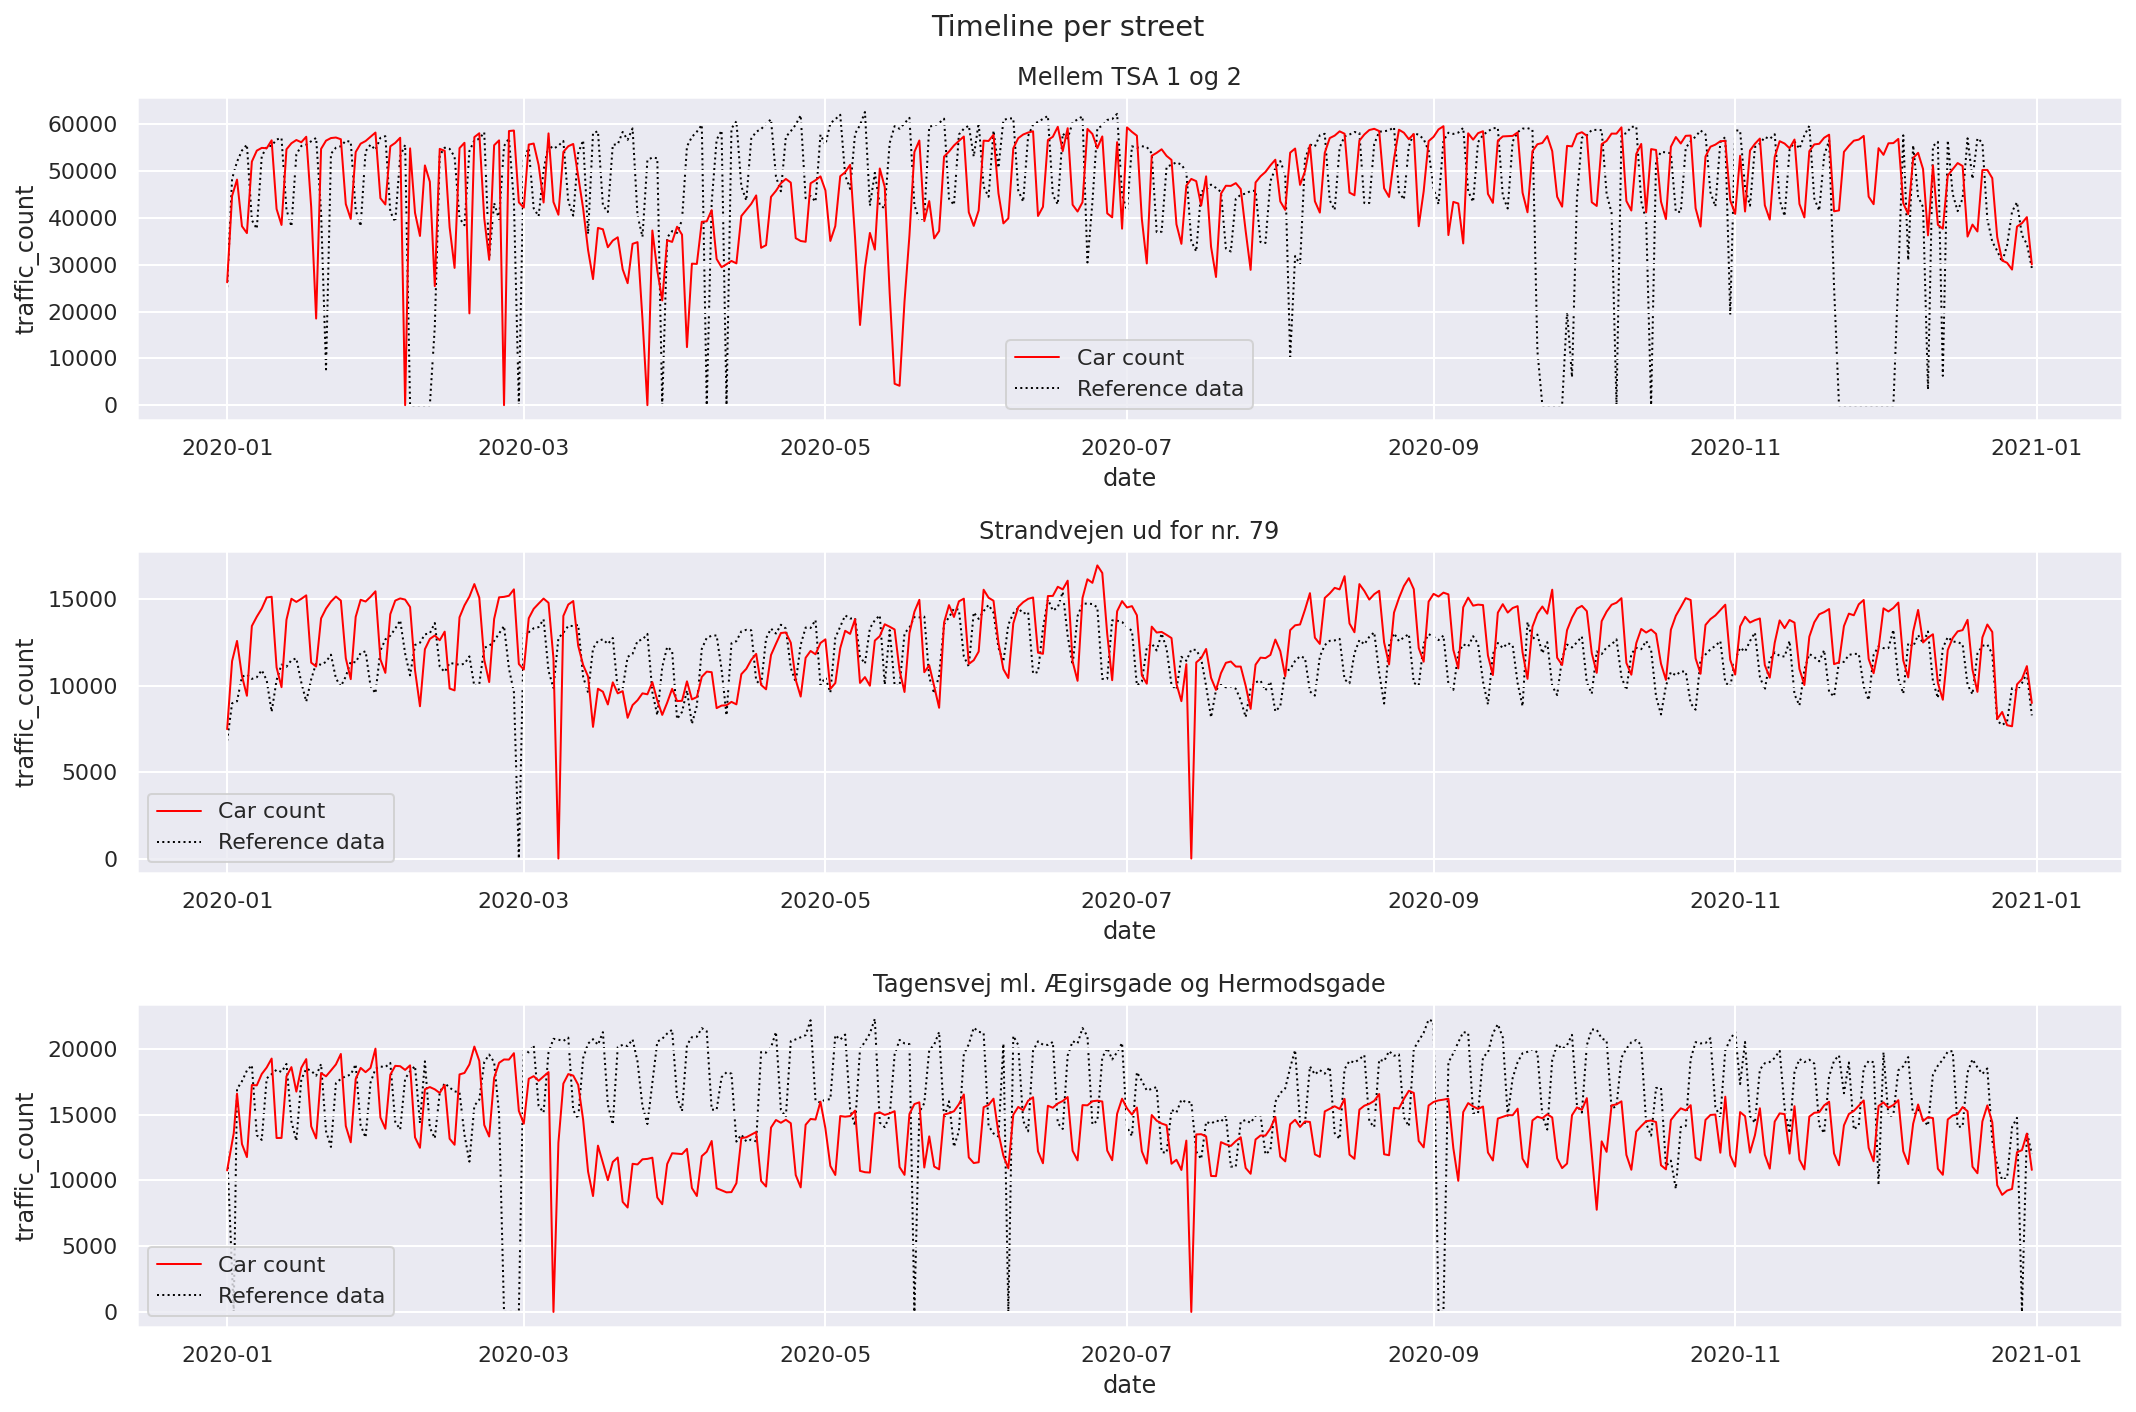

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        
numeric_columns = df_tc.select_dtypes(include=np.number).columns.tolist()
plot_kinds = ['hist', 'timeline', '']

for i, (street, column) in enumerate(zip(streets, numeric_columns)):
    df_tc_street = df_tc.loc[df_tc['street'] == street]
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count'], color='red', linewidth=1, ax=axes[i], label='Car count', zorder=1)
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count_ref'], color='black', linestyle='dotted', linewidth=1, ax=axes[i], label='Reference data', zorder=0)
    #for date, label in zip(COVID_DATES, ['First case', 'First lockdown', 'First reopening']):
    #        sns.scatterplot(x=df_tc_street['date'], y=df_tc_street.loc[df_tc_street['date'] == date]['traffic_count'], s=200, ax=axes[i], zorder=2, label=label)
        
    g.set_title(street)

fig.suptitle('Timeline per street')
plt.tight_layout()

**Timeline for traffic and COVID combined**

Text explaining whats visible in plot below

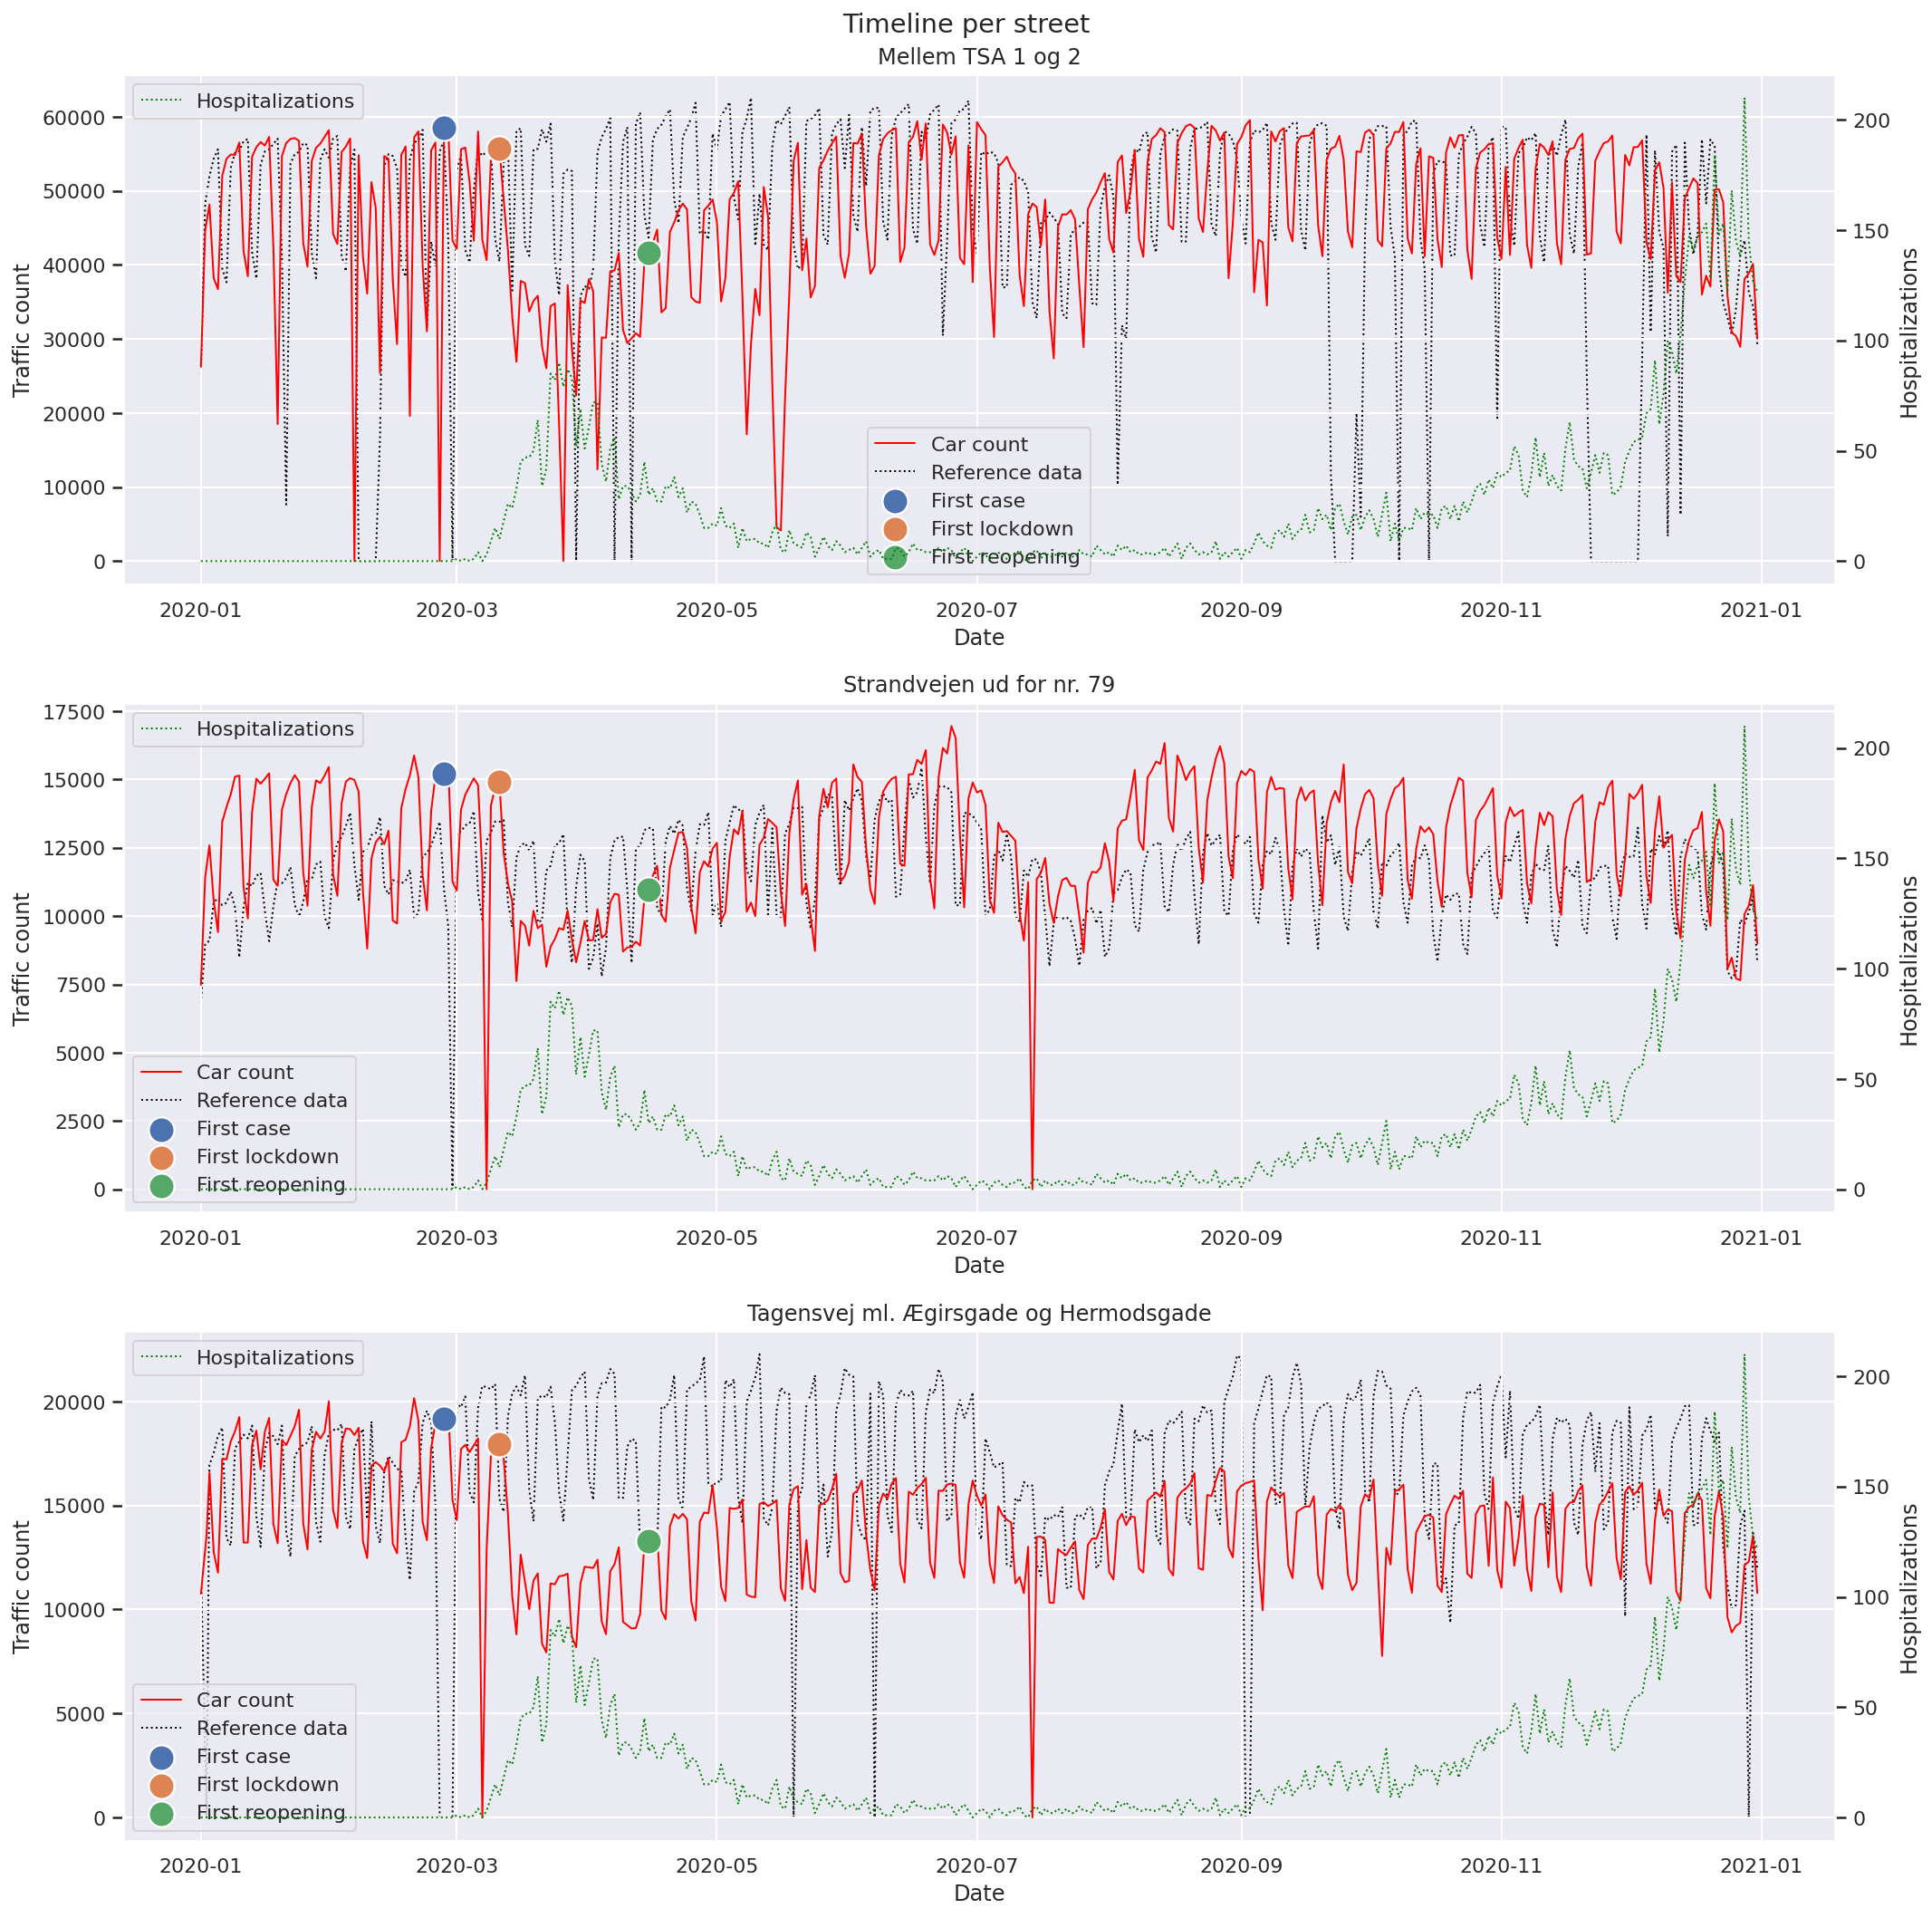

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

for i, street in enumerate(streets):
    df_tc_street = df_tc.loc[df_tc['street'] == street]
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count'], color='red', linewidth=1, ax=axes[i], label='Car count', zorder=1)
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count_ref'], color='black', linestyle='dotted', linewidth=1, ax=axes[i], label='Reference data', zorder=0)
    
    ax2 = axes[i].twinx()
    ax2.grid(False)
    g2 = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['hospitalizations'], color='green', linestyle='dotted', linewidth=1, axes=ax2, label='Hospitalizations')
    
    for date, label in zip(COVID_DATES, ['First case', 'First lockdown', 'First reopening']):
            sns.scatterplot(x=df_tc_street['date'], y=df_tc_street.loc[df_tc_street['date'] == date]['traffic_count'], s=200, ax=axes[i], zorder=2, label=label)
    
    g.set_title(street)
    g.set_xlabel('Date')
    g.set_ylabel('Traffic count')
    g2.set_ylabel('Hospitalizations')

fig.suptitle('Timeline per street')
plt.tight_layout()

In [32]:
df_tc

date 
 cases 
 hospitalizations 
 street 
 traffic_count 
 traffic_count_ref 
 
 
 
 
 0 
 2020-01-01 
 0.0 
 0.0 
 Mellem TSA 1 og 2 
 26232.0 
 25181.0 
 
 
 1 
 2020-01-01 
 0.0 
 0.0 
 Strandvejen ud for nr. 79 
 7484.0 
 6809.0 
 
 
 2 
 2020-01-01 
 0.0 
 0.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 10755.0 
 12221.0 
 
 
 3 
 2020-01-02 
 0.0 
 0.0 
 Mellem TSA 1 og 2 
 44669.0 
 48339.0 
 
 
 4 
 2020-01-02 
 0.0 
 0.0 
 Strandvejen ud for nr. 79 
 11421.0 
 8979.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1093 
 2020-12-30 
 2773.0 
 127.0 
 Strandvejen ud for nr. 79 
 11133.0 
 10727.0 
 
 
 1094 
 2020-12-30 
 2773.0 
 127.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 13555.0 
 13672.0 
 
 
 1095 
 2020-12-31 
 1232.0 
 122.0 
 Mellem TSA 1 og 2 
 30049.0 
 29302.0 
 
 
 1096 
 2020-12-31 
 1232.0 
 122.0 
 Strandvejen ud for nr. 79 
 8998.0 
 8284.0 
 
 
 1097 
 2020-12-31 
 1232.0 
 122.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 10795.0 
 12005.0 
 
 
 
 1098 rows × 6 columns

In [74]:
#Convert your DataFrame to Bokeh ColumnDataSource
src = ColumnDataSource(df_tc)

#Create an empty figure
p = figure(plot_width = 500, plot_height = 500, title = 'Title',
           x_axis_label = 'X label', y_axis_label = 'Y label') 

#Define the columns to use for each bar
bar_cols = ['traffic_count', 'traffic_count_ref']
legends = {'traffic_count': 'Traffic count', 'traffic_count_ref': 'Reference'}
colors = ['#ffffff', '#00ff00']

#Add bars by using p.var
bar ={} 
for i, col in enumerate(bar_cols):
    bar[col] = p.vbar(x=col,  top=col, source=src, width=10, 
                    legend_label=legends[col], color=colors[i], muted = True)
    
show(p)

# Final

# Motivation

> - What is your dataset?
> - Why did you choose this/these particular dataset(s)?
> - What was your goal for the end user's experience?

During the last few years, the societal behaviour of transportation has changed. At first, lockdowns throughout Denmark put limitations or different requirements on the way we travel. More recently, the rise of gas prices may have had similar impact on travel patterns. We will be doing an exploratory analysis of traffic behavior in the central Copenhagen area, to identify specific patterns and behaviour.

We have chosen 3 major data sets:
- Covid data set including hospitalisations.
- Traffic data from major roads in Copenhagen (The Danish Road Directorate).
- Historic gas-price data set.

We knew that covid had a big impact on the traffic inside of Copenhagen, since most of the work should now be conducted at home, leading to fewer cars on the road. In addition, it would be interesting to see if there is any other correlation with traffic. We chose the historic gas prices to see if expensive gas led to fever people taking the car. In addition, is it possible to predict traffic using gas prices?

> - Why did we choose this way to plot?
> - Why did we choose the time frame for covid/gas

# Basic stats
> - Write about your choices in data cleaning and preprocessing
> - Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

# Data Analysis
> - Describe your data analysis and explain what you've learned about the dataset. 
> - If relevant, talk about your machine-learning.


# Genre

> - Which genre of data story did you use?
> - Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
> - Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

# Visualizations

> - Explain the visualizations you've chosen.
> - Why are they right for the story you want to tell?

# Discussion

> - What went well?
> - What is still missing? What could be improved? Why?

# Contributions

# References

- [COVID-19 time line](http://thinkeuropa.dk/politik/tidslinje-over-coronakrisen-hvad-skete-der-og-hvornaar)
- [Consumer price index on gas](https://www.dst.dk/da/Statistik/emner/oekonomi/prisindeks/forbrugerprisindeks?tab=dok)
- [Encoding time](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)